# Generate Light Curves

## Converting from raw
### Tímto se z rawu udělá složka s tiff soubory:

for f in *.raw; do /home/roman/convert_raw12.sh $f & done

### A pak pomocí ffmpeg vygeneruji mp4

for f in */; do ffmpeg -i \\${f}_%06d.tiff -nostdin -loglevel panic -crf 0 ${f::-1}.mp4& done


### CSV s jasovou křivkou se generuje takhle:

for f in *.raw; do /home/roman/create_lightcurve.sh $f & done

### A tohle je gnuplot příkaz, který z toho udělá png graf:

for f in *.csv; do gnuplot -persist -e "set term png; set output '\\${f%.csv}.png'; set datafile separator comma; set logscale y; plot '$f' using 2 notitle with point" & done


In [260]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import time
import pandas as pd 
import matplotlib.dates as mdates

#directory = '/storage/experiments/2022/0520_bourka_nakv'
directory = '/storage/experiments/2022/0909_bourka_CAR1/chronos_mp4'
directory = '/storage/experiments/2022/0826_bourka_staryvestec_CAR1/chronos'
directory = '/storage/experiments/2022/0826_bourka_staryvestec_CAR0/chronos'
#directory = '/storage/experiments/2022/0721_bourka_neratovice_CAR1/chronos'
#directory = '/storage/experiments/2022/0714_bourka_horovice_CAR1/chronos'
#directory = '/storage/experiments/2022/0827_bourka_morava_CAR0/chronos'
#directory = '/storage/experiments/2022/0909_bourka_CAR0/chronos'
#directory = '/storage/experiments/2022/0906_bourka_CAR0/chronos'
#directory = '/storage/experiments/2022/0704_bourka_tesco_letnany/chronos'
#directory = '/storage/experiments/2022/0908_bourka_CAR1/chronos'
#directory = '/storage/experiments/2022/0714_bourka_horovice_CAR1/chronos'
#directory = '/storage/experiments/2022/0815_bourka_benesov_CAR1/chronos'
#directory = '/storage/experiments/2022/0815_bourka_kralupy_CAR0/chronos'
#directory = '/storage/experiments/2022/0819_bourka_staryvestec_CAR0/chronos'
#directory = '/storage/experiments/2022/0819_bourka_strancice_CAR1/chronos'
#directory = '/storage/experiments/2022/0825_bourka_D8_9km_CAR0/chronos'
#directory = '/storage/experiments/2022/0907_bourka_CAR0/chronos'
#directory = '/storage/experiments/2022/0825_bourka_D8_1km_CAR1/chronos'
#directory = '/storage/experiments/2022/0914_bourka_CAR1/chronos'
#directory = '/storage/experiments/2022/0908_bourka_CAR1/chronos'
#directory = '/storage/experiments/2024/0608_bourka_sobeslav/chronos'
#directory = '/storage/experiments/2024/0621_bourka_HK_Plzen_Sobeslav/chronos'
#directory = '/storage/experiments/2024/0628_bourka_hosin/'
#directory = '/storage/experiments/2024/0627_bourka_JH/chronos'
#directory = '/storage/experiments/2024/0703_bourka_D3/chronos'
directory = '/storage/experiments/2024/0727_bourka_sobeslav/chronos' # THUNDERMILL01
#directory = '/storage/experiments/2021/0609_bourka_sobeslav/video' # CG init

In [240]:
for f in glob.iglob(directory + "/*.mp4"): # generator, search immediate subdirectories 
    try:
        s = f.split('/')
        st = s[len(s)-1]

        b = np.zeros(30000)

        cap = cv2.VideoCapture(f)

        count = 0
        first = True
        while True:
            ret,frame = cap.read()

            if (not ret):
                break

            frame_old = frame
            crop_img = frame[0:859, 0:927] #frame[0:768, 0:1024]
            b[count] = crop_img.ravel().sum() #/ (860 * 928)
            
            #if (b[count] == 0):
            #    break
            count = count + 1

        cap.release()
        print(f, count)
        pd.DataFrame(b[:count]).to_csv(f + '.csv')
        
    except Exception as e: 
        print (e)
        pass
print('end')

/storage/experiments/2024/0727_bourka_sobeslav/chronos/2024-07-28_02-10-49_425459-lightning.mp4 4838
/storage/experiments/2024/0727_bourka_sobeslav/chronos/2024-07-28_01-46-36_838173-lightning.mp4 4838
end


In [3]:
# Urceni bitove hloubky TIFF

# Načtení TIFF obrázku
image_path = '/storage/experiments/2022/0826_bourka_staryvestec_CAR1/chronos/2022-08-26-16-41-56.904330-lightning/_000023.tiff'
#image_path = '/storage/experiments/2022/0826_bourka_staryvestec_CAR1/chronos/first_frame.png'
image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

# Získání bitové hloubky
bit_depth = image.dtype

# Převod datového typu na počet bitů
bit_depth_mapping = {
    'uint8': 8,
    'uint16': 16,
    'int16': 16,
    'float32': 32,
    'float64': 64
}

bit_depth_value = bit_depth_mapping[str(bit_depth)]

print(f'Bitová hloubka obrázku: {bit_depth_value} bitů')


Bitová hloubka obrázku: 16 bitů


In [12]:
def map_to_color(image):
    # Rozdělení 16bitové hodnoty na dva 8bitové kanály
    high_byte = (image >> 0) & 0xFF  # Horní 8 bitů
    #high_byte = ((image >> 0) & 0x80) | ((image >> 1) & 0x80) #| ((image << 1) & 0x80) | ((image << 2) & 0x80)   # Horní 8 bitů
    low_byte = (image >> 8) & 0xFF  # Dolní 4 bity
    #mid_byte = (image >> 6) & 0xFF  # Dolní 4 bity

    # Vytvoření třikanálového obrazu pro uložení dvou kanálů
    color_image = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    color_image[:, :, 0] = high_byte  # První barevný kanál
    color_image[:, :, 1] = low_byte   # Druhý barevný kanál
    # Třetí kanál můžete použít dle potřeby, např. kopii jednoho z předchozích
    color_image[:, :, 2] = high_byte

    return color_image

# Definujte cestu k vašim TIFF obrázkům a výstupnímu videu
input_folder = '/storage/experiments/2022/0826_bourka_staryvestec_CAR0/chronos/2022-08-26-16-11-32.607715-lightning'
output_video = '/storage/experiments/2022/0826_bourka_staryvestec_CAR0/chronos/color/output_video.mp4'
input_folder = '/storage/experiments/2024/0727_bourka_sobeslav/chronos/2024-07-28_02-10-49_425459-lightning'
output_video = '/storage/experiments/2024/0727_bourka_sobeslav/chronos/color/output_video.mp4'

# Načtení všech TIFF obrázků
tiff_files = sorted([f for f in os.listdir(input_folder) if f.endswith('.tiff')])

# Načtení prvního obrázku pro získání rozměrů
first_image = cv2.imread(os.path.join(input_folder, tiff_files[0]), cv2.IMREAD_UNCHANGED)
height, width = first_image.shape

# Vytvoření VideoWriter objektu
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_writer = cv2.VideoWriter(output_video, fourcc, 30, (width, height))

n = 0

for file in tiff_files:
    # Načtení 16bitového TIFF obrázku
    image = cv2.imread(os.path.join(input_folder, file), cv2.IMREAD_UNCHANGED)
    
    n = n + 1
    
    # rozsah videa, ktery nas zajima
    if (n<1800):
        continue   
    if (n>2000):
        continue

    # Mapování na nepravé barvy zachovávající 16bitové rozlišení
    colored_img = map_to_color(image)
    
    # Zápis do videa
    video_writer.write(colored_img)

# Uvolnění VideoWriter objektu
video_writer.release()

print('Video successfully created.')


Video successfully created.


In [47]:
def map_to_color(image):
    # Rozdělení 16bitové hodnoty na dva 8bitové kanály
    #high_byte = (image >> 0) & 0xFF  # Horní 8 bitů
    high_byte = ((image >> 0) & 0xFF) #| ((image >> 1) & 0x80) #| ((image << 1) & 0x80) | ((image << 2) & 0x80)   # Horní 8 bitů
    low_byte = (image >> 5) & 0xFF  # Dolní 4 bity
    mid_byte = (image >> 6) & 0xFF  # Dolní 4 bity

    # Vytvoření třikanálového obrazu pro uložení dvou kanálů
    color_image = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    color_image[:, :, 0] = high_byte  # První barevný kanál
    color_image[:, :, 1] = high_byte   # Druhý barevný kanál
    # Třetí kanál můžete použít dle potřeby, např. kopii jednoho z předchozích
    color_image[:, :, 2] = high_byte

    return color_image

# Definujte cestu k vašim TIFF obrázkům a výstupnímu videu
input_folder = '/storage/experiments/2022/0826_bourka_staryvestec_CAR0/chronos/2022-08-26-16-11-32.607715-lightning'
input_folder = '/storage/experiments/2024/06_camera_test/vid_2024-06-25_20-13-03'
input_folder = '/storage/experiments/2024/06_camera_test/vid_2024-06-25_20-24-09'
output_video = '/storage/experiments/2024/06_camera_test/output_video.mp4'

# Načtení všech TIFF obrázků
tiff_files = sorted([f for f in os.listdir(input_folder) if f.endswith('.tiff')])

# Načtení prvního obrázku pro získání rozměrů
first_image = cv2.imread(os.path.join(input_folder, tiff_files[0]), cv2.IMREAD_UNCHANGED)
height, width = first_image.shape

# Vytvoření VideoWriter objektu
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_writer = cv2.VideoWriter(output_video, fourcc, 30, (width, height))

n = 0

for file in tiff_files:
    # Načtení 16bitového TIFF obrázku
    image = cv2.imread(os.path.join(input_folder, file), cv2.IMREAD_UNCHANGED)
    
    n = n + 1
    
    # Mapování na nepravé barvy zachovávající 16bitové rozlišení
    colored_img = map_to_color(image)
    
    # Zápis do videa
    video_writer.write(colored_img)

# Uvolnění VideoWriter objektu
video_writer.release()

print('Video successfully created.')


Video successfully created.


In [17]:
import os
import cv2
import numpy as np

# Definujte cestu k vašim TIFF obrázkům
input_folder = '/storage/experiments/2022/0826_bourka_staryvestec_CAR0/chronos/2022-08-26-16-11-32.607715-lightning'

# Načtení všech TIFF obrázků
tiff_files = sorted([f for f in os.listdir(input_folder) if f.endswith('.tiff')])

# Inicializace proměnných pro maximální a minimální hodnoty
global_min = float('inf')
global_max = float('-inf')

for file in tiff_files:
    # Načtení 16bitového TIFF obrázku
    image = cv2.imread(os.path.join(input_folder, file), cv2.IMREAD_UNCHANGED)
    
    # Zjištění minimální a maximální hodnoty jasu v aktuálním obrázku
    min_val = np.min(image)
    max_val = np.max(image)
    
    # Aktualizace globálních minimálních a maximálních hodnot
    if min_val < global_min:
        global_min = min_val
    if max_val > global_max:
        global_max = max_val

print(f'Globální minimální hodnota jasu: {global_min}')
print(f'Globální maximální hodnota jasu: {global_max}')


Globální minimální hodnota jasu: 0
Globální maximální hodnota jasu: 56304


In [55]:
import os
import cv2
import numpy as np

# Definujte cestu k vašim TIFF obrázkům
input_folder = '/storage/experiments/2022/0826_bourka_staryvestec_CAR0/chronos/2022-08-26-16-11-32.607715-lightning'

# Načtení všech TIFF obrázků
tiff_files = sorted([f for f in os.listdir(input_folder) if f.endswith('.tiff')])

# Inicializace proměnné pro složený obraz
composite_image = None

n = 0

for file in tiff_files:
    # Načtení 16bitového TIFF obrázku
    image = cv2.imread(os.path.join(input_folder, file), cv2.IMREAD_UNCHANGED)
    
    n = n + 1
    
    # rozsah videa, ktery nas zajima
    if (n<1500):
        continue   
    if (n>3000):
        continue
    
    if composite_image is None:
        # Inicializace složeného obrazu na základě prvního načteného obrázku
        composite_image = image
    else:
        # Složení obrazu pomocí maximální hodnoty pixelů
        composite_image = np.maximum(composite_image, image)

# Normalizace složeného obrazu do rozsahu 0-255 pro zobrazení
normalized_composite_image = cv2.normalize(composite_image, None, 0, 255, cv2.NORM_MINMAX)
normalized_composite_image = np.uint8(normalized_composite_image)

# Uložení složeného obrazu
output_path = '/storage/experiments/2022/0826_bourka_staryvestec_CAR0/chronos/color/composite_image.png'
cv2.imwrite(output_path, normalized_composite_image)

print(f'Složený obraz byl uložen jako {output_path}')


Složený obraz byl uložen jako /storage/experiments/2022/0826_bourka_staryvestec_CAR0/chronos/color/composite_image.png


In [53]:
import os
import cv2
import numpy as np

# Definujte cestu k vašim TIFF obrázkům
input_folder = '/storage/experiments/2022/0826_bourka_staryvestec_CAR0/chronos/2022-08-26-16-11-32.607715-lightning'

# Načtení všech TIFF obrázků
tiff_files = sorted([f for f in os.listdir(input_folder) if f.endswith('.tiff')])

# Inicializace proměnné pro složený obraz
composite_image = None

# Inicializace pro předchozí obrázek pro výpočet rozdílů
previous_image = None

n=0

for file in tiff_files:
    # Načtení 16bitového TIFF obrázku
    image = cv2.imread(os.path.join(input_folder, file), cv2.IMREAD_UNCHANGED)

    n = n + 1
    
    if (n<1500):
        continue
    
    if composite_image is None:
        # Inicializace složeného obrazu na základě prvního načteného obrázku
        composite_image = np.zeros_like(image, dtype=np.float32)
    
    if previous_image is not None:
        # Výpočet absolutního rozdílu mezi aktuálním a předchozím obrázkem
        diff_image = cv2.absdiff(image, previous_image)
        
        # Prahování rozdílů k odstranění šumu a zvýraznění významných změn
        #_, thresh_image = cv2.threshold(diff_image, 0, 65535, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        # Použití rozdílu pro aktualizaci složeného obrazu
        composite_image += (diff_image.astype(np.float32) * (image.astype(np.float32) / 65535))
    
    # Aktualizace předchozího obrázku
    previous_image = image

# Normalizace složeného obrazu do rozsahu 0-65535 pro zobrazení
normalized_composite_image = cv2.normalize(composite_image, None, 0, 65535, cv2.NORM_MINMAX)
normalized_composite_image = np.uint16(normalized_composite_image)

# Uložení složeného obrazu ve formátu TIFF
output_path = '/storage/experiments/2022/0826_bourka_staryvestec_CAR0/chronos/color/composite_image.tiff'
cv2.imwrite(output_path, normalized_composite_image)

print(f'Složený obraz byl uložen jako {output_path}')


Složený obraz byl uložen jako /storage/experiments/2022/0826_bourka_staryvestec_CAR0/chronos/color/composite_image.tiff


# Plot Light Curves

/storage/experiments/2022/0826_bourka_staryvestec_CAR0/chronos/2022-08-26-16-00-33.038456-lightning.mp4.csv


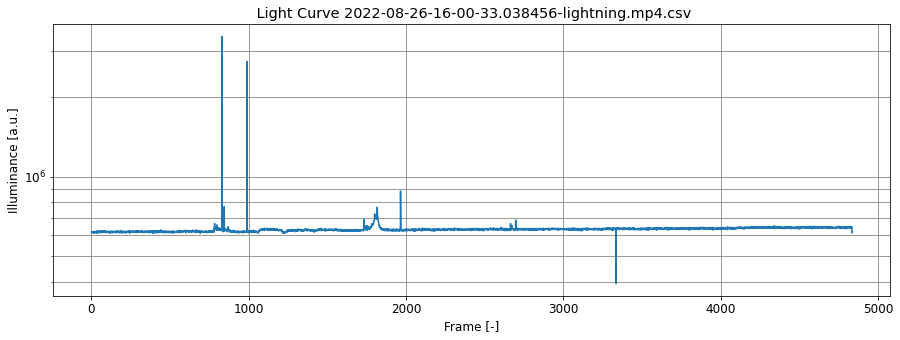

/storage/experiments/2022/0826_bourka_staryvestec_CAR0/chronos/2022-08-26-16-45-44.879622-lightning.mp4.csv


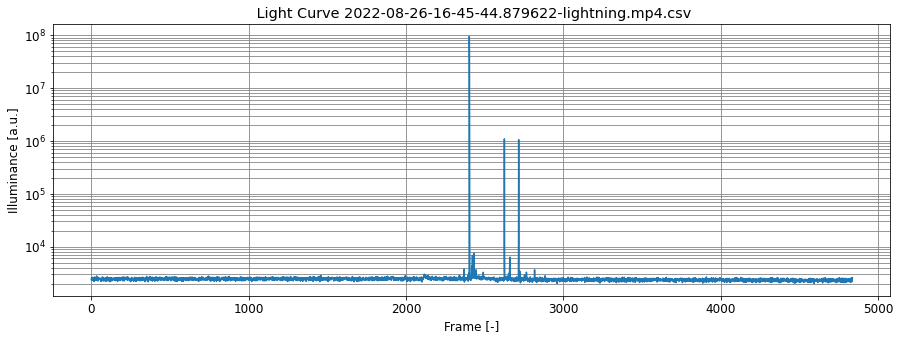

/storage/experiments/2022/0826_bourka_staryvestec_CAR0/chronos/2022-08-26-17-12-39.402083-lightning.mp4.csv


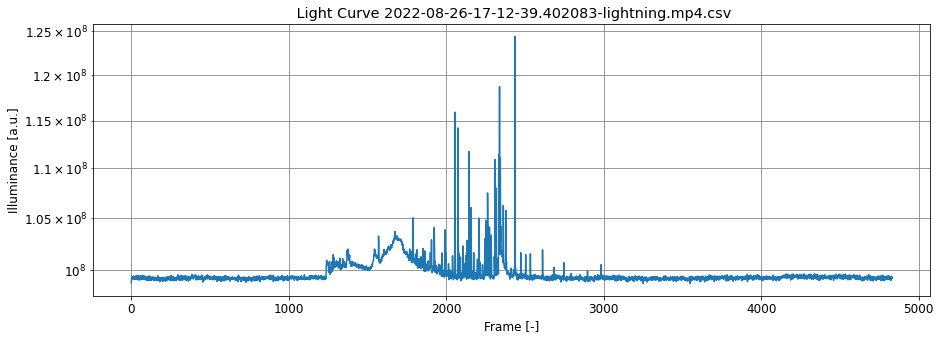

/storage/experiments/2022/0826_bourka_staryvestec_CAR0/chronos/2022-08-26-16-03-41.278526-lightning.mp4.csv


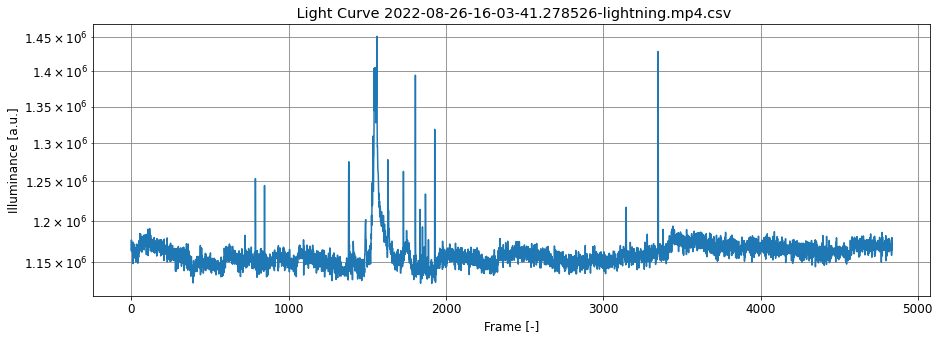

/storage/experiments/2022/0826_bourka_staryvestec_CAR0/chronos/2022-08-26-16-11-32.607715-lightning.mp4.csv


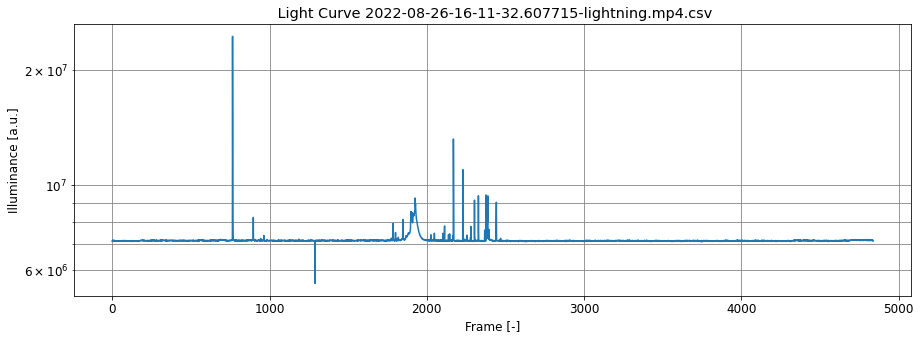

/storage/experiments/2022/0826_bourka_staryvestec_CAR0/chronos/2022-08-26-17-10-16.906691-lightning.mp4.csv


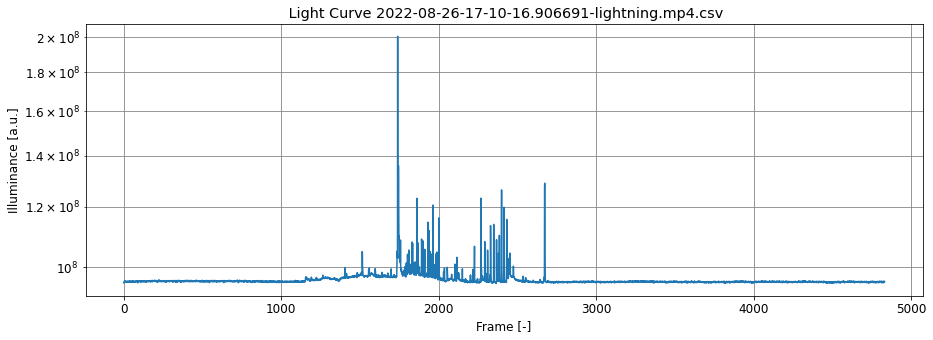

/storage/experiments/2022/0826_bourka_staryvestec_CAR0/chronos/2022-08-26-16-34-02.275285-lightning.mp4.csv


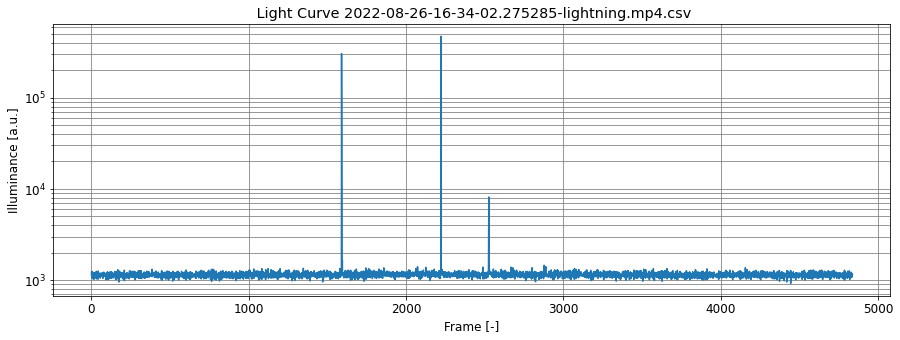

/storage/experiments/2022/0826_bourka_staryvestec_CAR0/chronos/2022-08-26-16-49-32.316789-lightning.mp4.csv


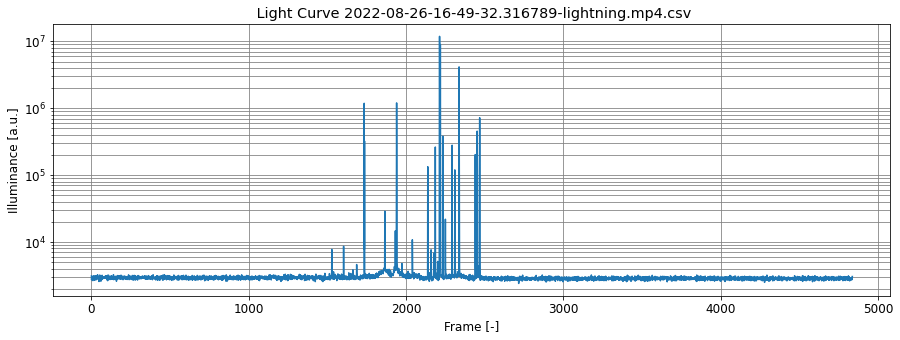

/storage/experiments/2022/0826_bourka_staryvestec_CAR0/chronos/2022-08-26-17-53-01.520895-lightning.mp4.csv


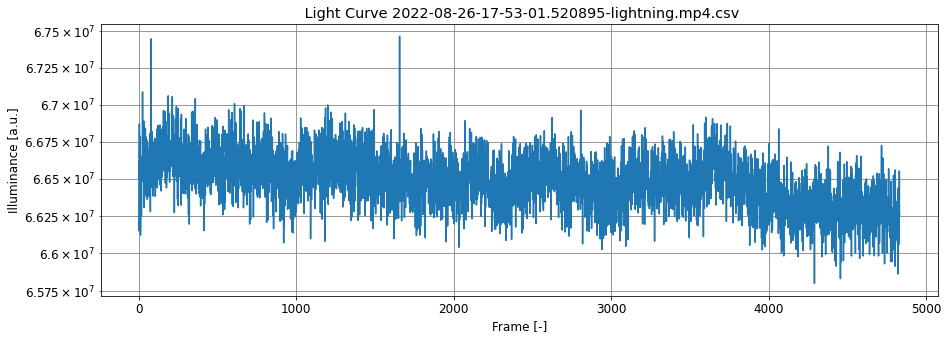

/storage/experiments/2022/0826_bourka_staryvestec_CAR0/chronos/2022-08-26-15-57-21.476986-lightning.mp4.csv


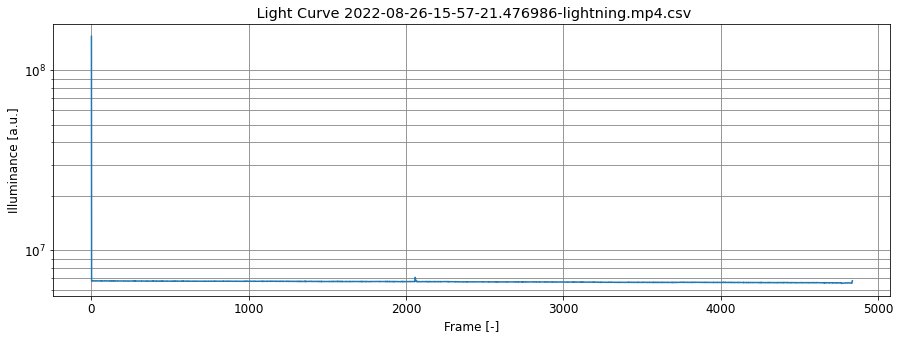

/storage/experiments/2022/0826_bourka_staryvestec_CAR0/chronos/2022-08-26-16-57-12.997069-lightning.mp4.csv


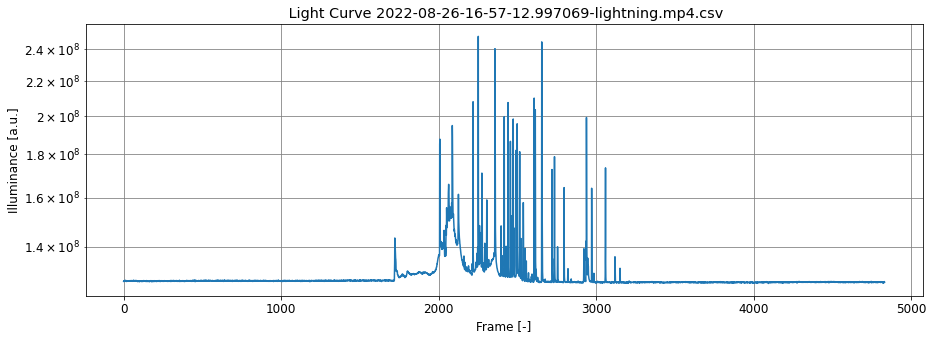

/storage/experiments/2022/0826_bourka_staryvestec_CAR0/chronos/2022-08-26-17-42-50.096528-lightning.mp4.csv


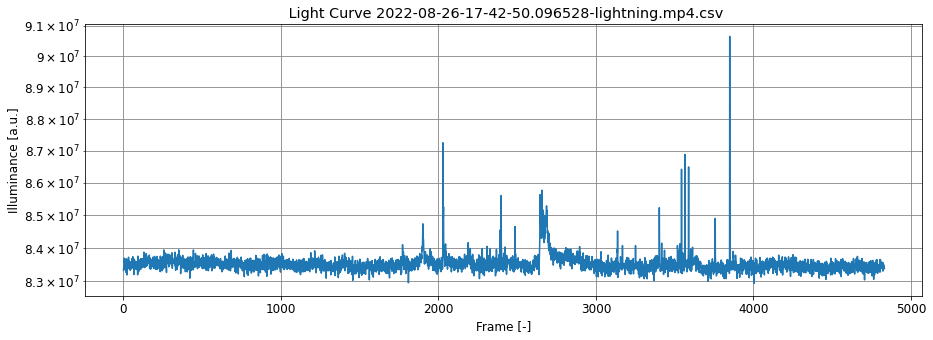

/storage/experiments/2022/0826_bourka_staryvestec_CAR0/chronos/2022-08-26-17-45-06.423515-lightning.mp4.csv


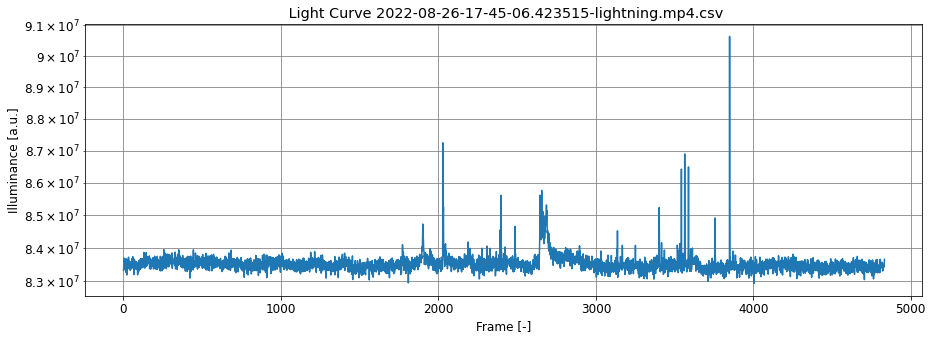

/storage/experiments/2022/0826_bourka_staryvestec_CAR0/chronos/2022-08-26-17-40-30.377539-lightning.mp4.csv


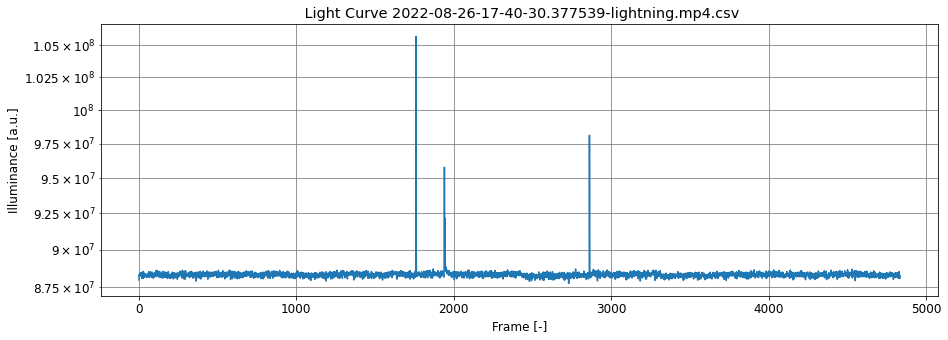

/storage/experiments/2022/0826_bourka_staryvestec_CAR0/chronos/2022-08-26-16-41-56.914651-lightning.mp4.csv


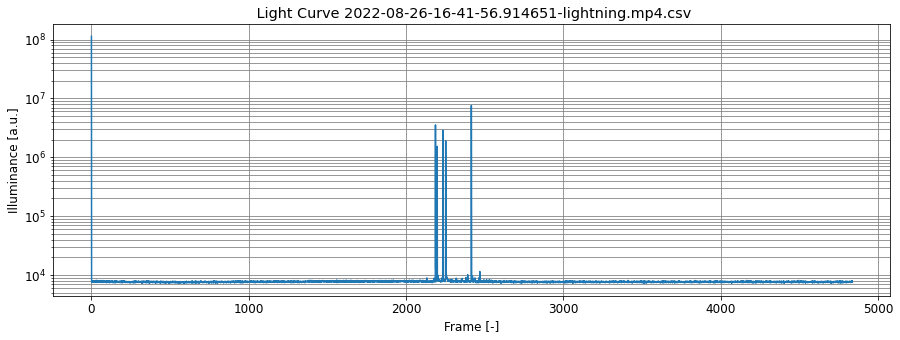

/storage/experiments/2022/0826_bourka_staryvestec_CAR0/chronos/2022-08-26-16-26-22.597718-lightning.mp4.csv


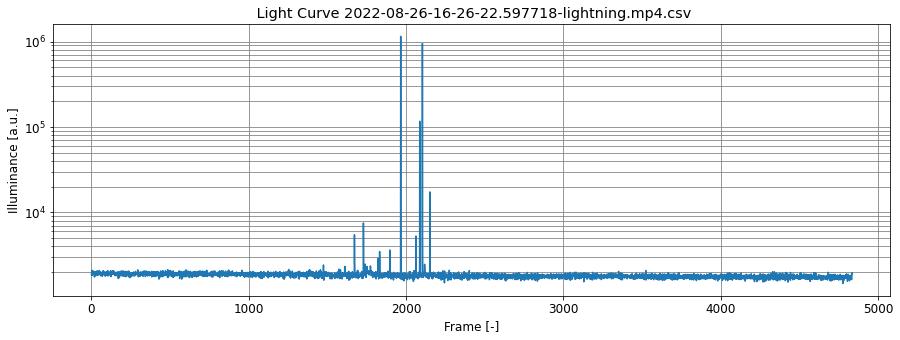

/storage/experiments/2022/0826_bourka_staryvestec_CAR0/chronos/2022-08-26-16-38-03.495791-lightning.mp4.csv


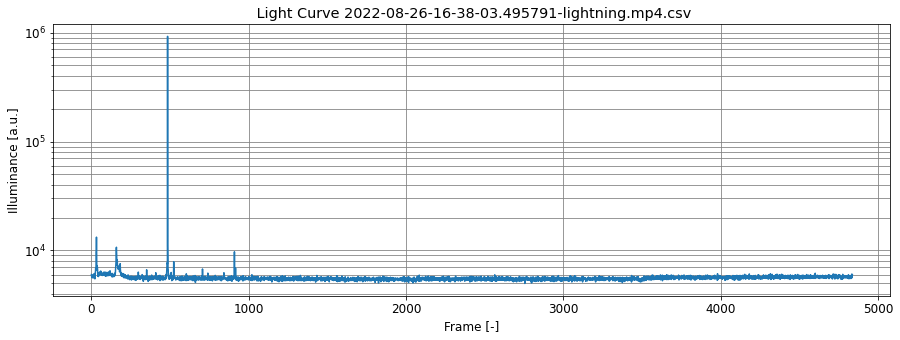

/storage/experiments/2022/0826_bourka_staryvestec_CAR0/chronos/2022-08-26-16-22-22.896395-lightning.mp4.csv


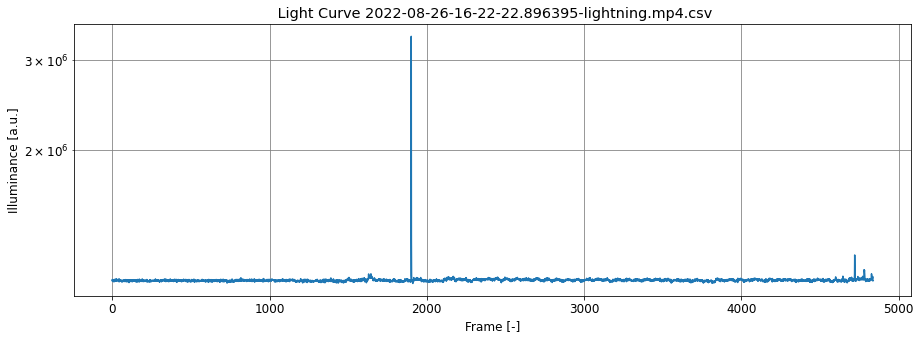

/storage/experiments/2022/0826_bourka_staryvestec_CAR0/chronos/2022-08-26-16-14-33.530507-lightning.mp4.csv


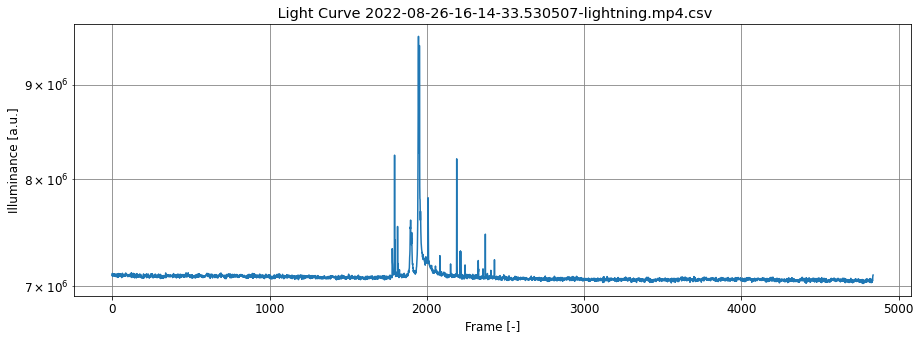

/storage/experiments/2022/0826_bourka_staryvestec_CAR0/chronos/2022-08-26-17-06-00.755449-lightning.mp4.csv


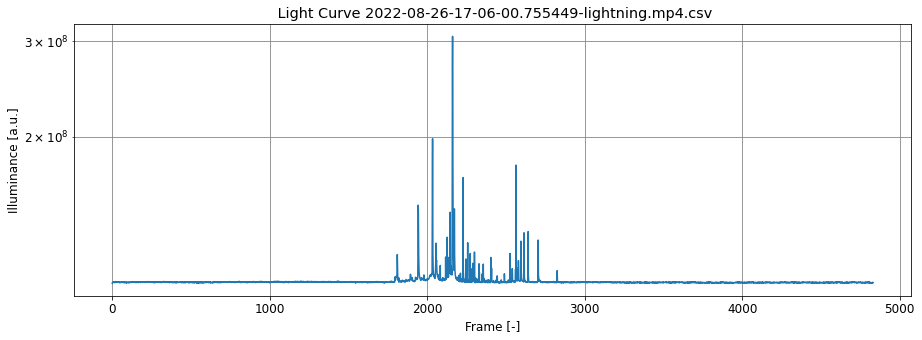

/storage/experiments/2022/0826_bourka_staryvestec_CAR0/chronos/2022-08-26-17-17-19.205389-lightning.mp4.csv


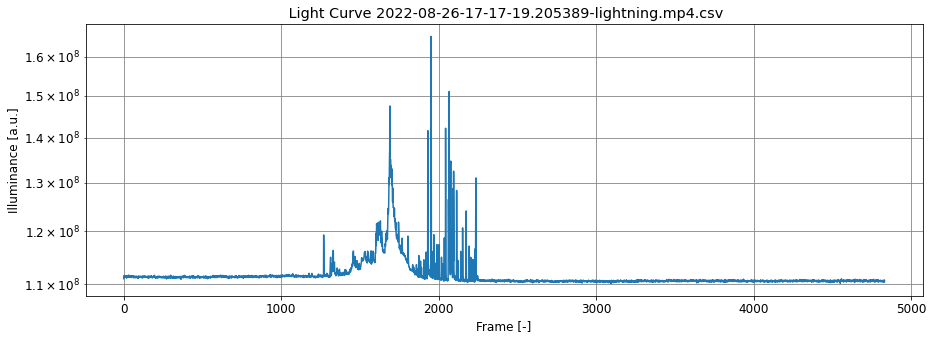

/storage/experiments/2022/0826_bourka_staryvestec_CAR0/chronos/2022-08-26-16-19-02.680727-lightning.mp4.csv


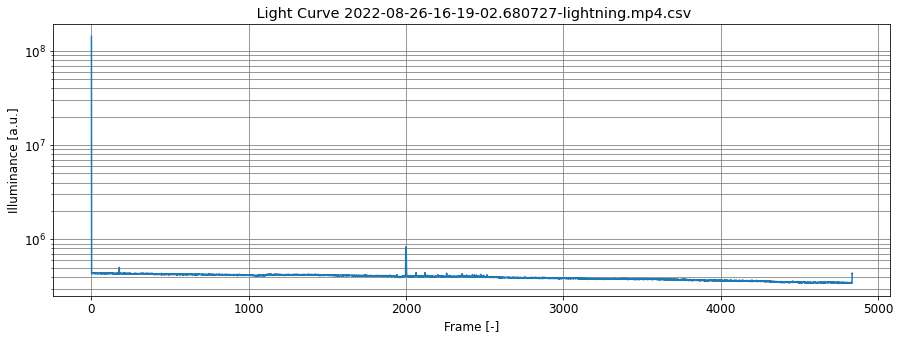

/storage/experiments/2022/0826_bourka_staryvestec_CAR0/chronos/2022-08-26-17-03-19.290817-lightning.mp4.csv


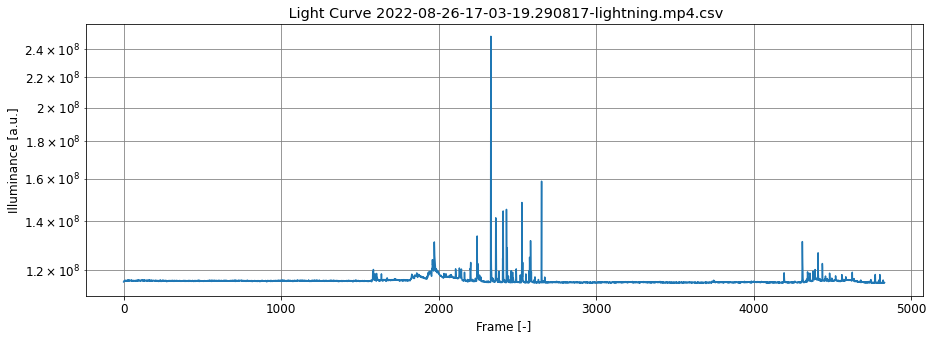

/storage/experiments/2022/0826_bourka_staryvestec_CAR0/chronos/2022-08-26-17-21-56.284351-lightning.mp4.csv


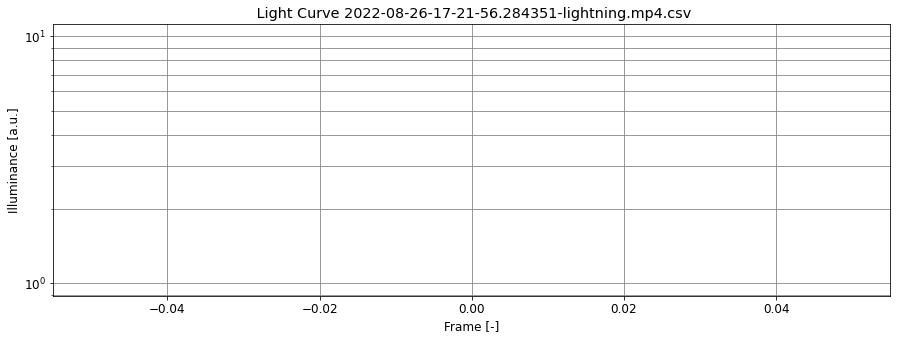

/storage/experiments/2022/0826_bourka_staryvestec_CAR0/chronos/2022-08-26-17-00-05.526576-lightning.mp4.csv


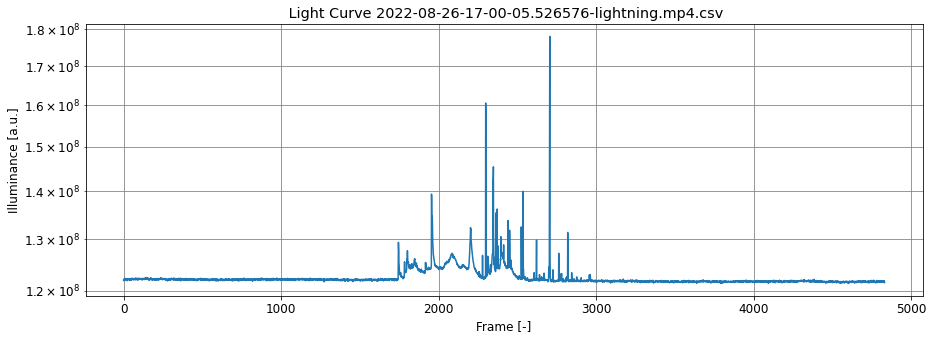

/storage/experiments/2022/0826_bourka_staryvestec_CAR0/chronos/2022-08-26-17-49-28.738040-lightning.mp4.csv


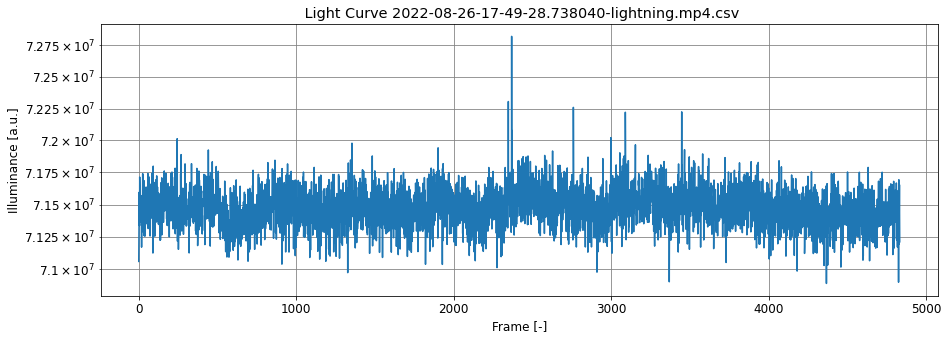

/storage/experiments/2022/0826_bourka_staryvestec_CAR0/chronos/2022-08-26-17-14-55.926945-lightning.mp4.csv


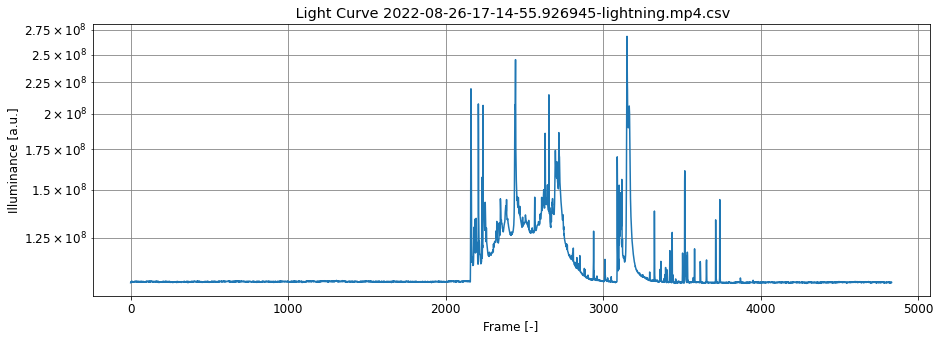

/storage/experiments/2022/0826_bourka_staryvestec_CAR0/chronos/2022-08-26-15-51-17.933107-lightning.mp4.csv


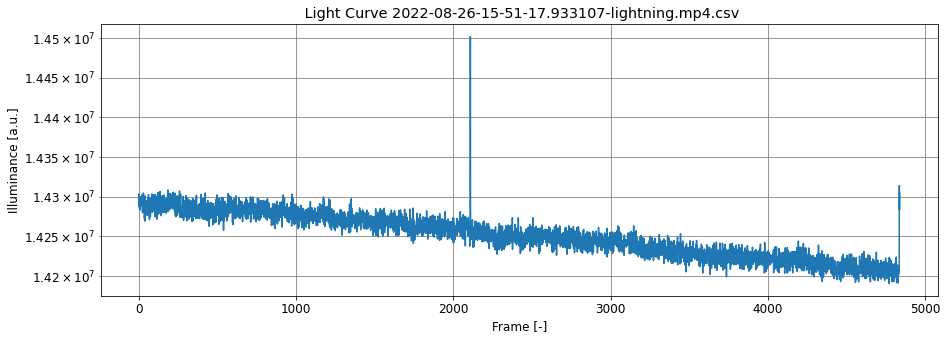

/storage/experiments/2022/0826_bourka_staryvestec_CAR0/chronos/2022-08-26-16-09-04.213386-lightning.mp4.csv


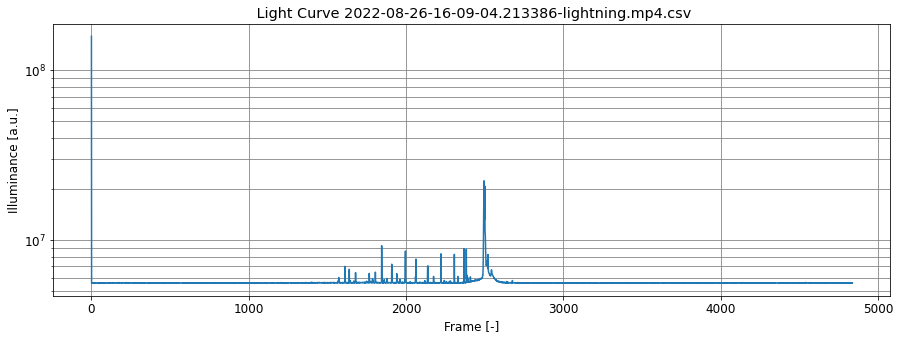

/storage/experiments/2022/0826_bourka_staryvestec_CAR0/chronos/2022-08-26-16-30-22.435107-lightning.mp4.csv


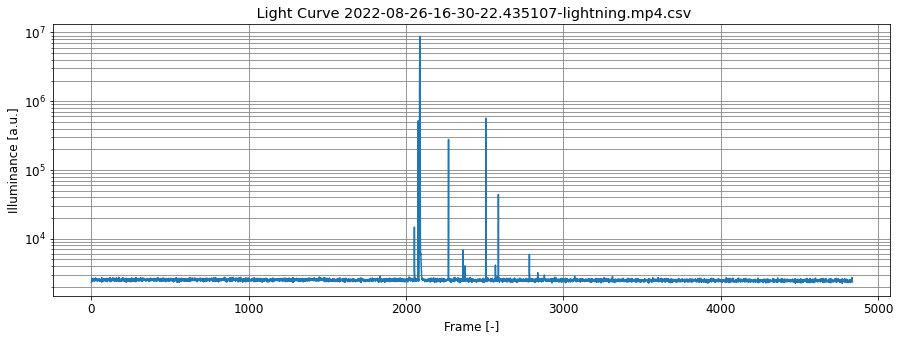

/storage/experiments/2022/0826_bourka_staryvestec_CAR0/chronos/2022-08-26-16-06-18.739759-lightning.mp4.csv


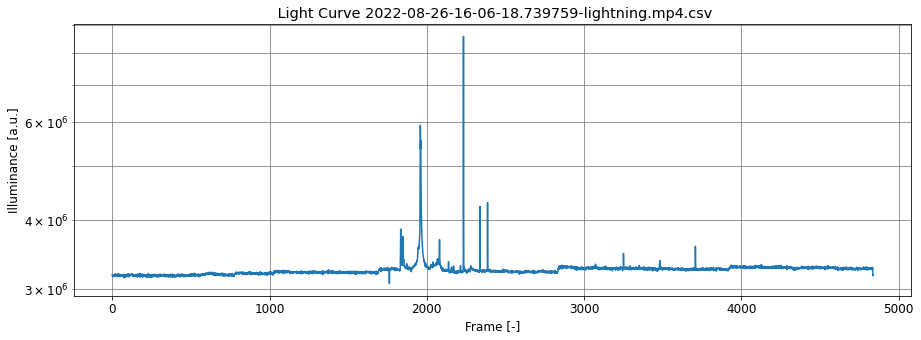

In [219]:
for f in glob.iglob(directory + "/*.mp4.csv"): # generator, search immediate subdirectories 
    try:
        s = f.split('/')
        st = s[len(s)-1]
        print(f)
        y = pd.read_csv(f)

        plt.figure(figsize=(15,5))
        plt.rc('font', size=12)    

        plt.plot(y['0'])
        plt.yscale('log')
        plt.title(' Light Curve ' + st)
        plt.xlabel('Frame [-]')
        plt.ylabel('Illuminance [a.u.]')
        plt.grid(visible=True, which='major', color='grey', linestyle='-')
        plt.grid(visible=True, which='minor', color='grey', linestyle='-')
        #plt.xticks(np.arange(0, 4000, 100))
        plt.show()

    except:
        pass


# Generate images with lightcurves

In [4]:
os.mkdir(directory + '/output')

In [257]:
for f in glob.iglob(directory + "/*11-32*.mp4"): # generator, search immediate subdirectories 
    s = f.split('/')
    st = s[len(s)-1]
    print(f)
    y = pd.read_csv(f + '.csv')    
    
    vcap = cv2.VideoCapture(f)

    if vcap.isOpened(): 
        # get vcap property 
        width  = vcap.get(3)  # float `width`
        height = vcap.get(4)  # float `height`
        
    print(width, ' x ', height)

    #w = 9.29
    w = (width+1)/100
    h = 1.5

    fig = plt.figure(frameon=False)
    fig.set_size_inches(w,h)
    fig.tight_layout()
    #ax = plt.Axes(fig, [0, 0, 1, 1])
    #ax.set_axis_off()
    #fig.add_axes(ax)
    
    ax = fig.add_axes([0, 0, 1, 1])
    plt.axis('off')    
    
    #plt.plot(y.iloc[1:].index,y.iloc[1:]['0'], color='black', linewidth=0.3)
    plt.plot(y.index,y['0'], color='black', linewidth=0.3)
    plt.yscale('log')
    plt.xlim([0,len(y)])
    fig.savefig(directory + '/output/' + st + '.csv.png', dpi=100, bbox_inches='tight', pad_inches = 0)
    plt.show()

None

# Insert Images with lightcurves in to videos

In [259]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import time
import pandas as pd 

#directory = "/storage/experiments/2021/0711_bourka_stiavnica"

# Logarithmic transformation
def log(c, img):
    output = c * np.log(1.0 + img)
    output = np.uint8(output + 0.5)
    return output

try:
    os.mkdir(directory + '/output')
except:
    pass

for f in glob.iglob(directory + "/*09-04*.mp4"): # generator, search immediate subdirectories 
    s = f.split('/')
    st = s[len(s)-1]
    print(st)

    b = np.zeros(30000)

    vcap = cv2.VideoCapture(f)

    if vcap.isOpened(): 
        # get vcap property 
        width  = vcap.get(3)  # float `width`
        height = vcap.get(4)  # float `height`

    print(width, ' x ', height)
    vcap.release()

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    #out = cv2.VideoWriter(directory + '/video/output/' + st , fourcc, 20.0, (928,928+150))
    out = cv2.VideoWriter(directory + '/output/' + st, fourcc, 20.0, (round(width),round(height)+150))

    cap = cv2.VideoCapture(f)
    video_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(video_length)

    img = cv2.imread(directory + '/output/' + st + '.csv.png')
    img_not = cv2.bitwise_not(img)

    # Center coordinates
    center_coordinates = (round(width/2), round(height/2))
    # Radius of circle
    radius = round(width/2)-45
    # Line thickness in px
    line_thickness = 1
    font_thickness = 1
    font_scale = 0.8

    count = 0
    while True:
        ret,frame = cap.read()
        if not(ret):
            break
            
        count = count + 1
        if((count>1)):
            for n in range(0,256):
                for i in range(round(width)-20,round(width)):
                    frame[n+20,i] = n

            #(B, G, R) = cv2.split(frame)
            #frame = cv2.merge([B,B,B])
            #frame_log = log(42,frame)
            frame_color = frame[:round(width)-40]

            frame_color = cv2.applyColorMap(frame_color, cv2.COLORMAP_JET)
            
            color = (0, 255, 0) # green
            cv2.circle(frame_color, center_coordinates, radius, color, 1, cv2.LINE_AA)

            font = cv2.FONT_HERSHEY_DUPLEX
            text = "W" # vpravo
            position = (round(width/2)-10, 80)
            cv2.putText(frame_color, text, position, font, color=color, thickness = font_thickness, fontScale=font_scale, lineType = cv2.LINE_AA)
            text = "E" # vlevo
            position = (round(width/2)-10, round(width) -70)
            cv2.putText(frame_color, text, position, font, color=color, thickness = font_thickness, fontScale=font_scale, lineType = cv2.LINE_AA)
            text = "S" # vpredu
            position = (round(width)-80, round(width/2)+10)
            cv2.putText(frame_color, text, position, font, color=color, thickness = font_thickness, fontScale=font_scale, lineType = cv2.LINE_AA)
            text = "N" # vzadu
            position = (60, round(width/2)+10)
            cv2.putText(frame_color, text, position, font, color=color, thickness = font_thickness, fontScale=font_scale, lineType = cv2.LINE_AA)
            font = cv2.FONT_HERSHEY_SIMPLEX
            color = (255, 255, 255) # white
            text = "0"
            position = (round(width) - 35, 40)
            cv2.putText(frame_color, text, position, font, color=color, thickness = font_thickness, fontScale=font_scale-0.2, lineType = cv2.LINE_AA)
            text = "255"
            position = (round(width) - 60, 275)
            cv2.putText(frame_color, text, position, font, color=color, thickness = font_thickness, fontScale=font_scale-0.2, lineType = cv2.LINE_AA)
                                    
            v_img = cv2.vconcat([img_not, frame_color, frame[round(width)-40:round(width)]])

            pointer = round(count*(width/video_length))
            cv2.line(v_img,(pointer,140),(pointer,160),(0,255,0),2)
            cv2.line(v_img,(pointer,60),(pointer,80),(0,255,0),2)
            out.write(v_img)
            #cv2.imwrite(directory + '/video/output/ble.png', v_img)     # save frame as JPEG file
            #break

    cap.release()
    out.release()
    print(f)
        
print('end')

2022-08-26-16-09-04.213386-lightning.mp4
928.0  x  928.0
4838
/storage/experiments/2022/0826_bourka_staryvestec_CAR0/chronos/2022-08-26-16-09-04.213386-lightning.mp4
end


# Logarithmic luminiscence

In [228]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import time
import pandas as pd 

#directory = "/storage/experiments/2021/0711_bourka_stiavnica"

# Logarithmic transformation
def log(c, img):
    output = c * np.log(1.0 + img)
    output = np.uint8(output + 0.5)
    return output

try:
    os.mkdir(directory + '/output')
except:
    pass

for f in glob.iglob(directory + "/*09-04*.mp4"): # generator, search immediate subdirectories 
    s = f.split('/')
    st = s[len(s)-1]
    print(st)

    b = np.zeros(30000)

    vcap = cv2.VideoCapture(f)

    if vcap.isOpened(): 
        # get vcap property 
        width  = vcap.get(3)  # float `width`
        height = vcap.get(4)  # float `height`

    print(width, ' x ', height)
    vcap.release()

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    #out = cv2.VideoWriter(directory + '/video/output/' + st , fourcc, 20.0, (928,928+150))
    out = cv2.VideoWriter(directory + '/output/' + st, fourcc, 20.0, (round(width),round(height)+150))

    cap = cv2.VideoCapture(f)
    video_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(video_length)

    img = cv2.imread(directory + '/output/' + st + '.csv.png')
    img_not = cv2.bitwise_not(img)

    # Center coordinates
    center_coordinates = (round(width/2), round(height/2))
    # Radius of circle
    radius = round(width/2)-45
    # Line thickness in px
    line_thickness = 1
    font_thickness = 1
    font_scale = 0.8

    count = 0
    while True:
        ret,frame = cap.read()
        if not(ret):
            break
            
        count = count + 1
        if((count>1700)and(count<2500)):
            for n in range(0,256):
                for i in range(round(width)-20,round(width)):
                    frame[n+20,i] = n

            #(B, G, R) = cv2.split(frame)
            #frame = cv2.merge([B,B,B])
            frame_log = log(2,frame)
            frame_color = frame_log[:round(width)-40]

            frame_color = cv2.applyColorMap(frame_color, cv2.COLORMAP_JET)
            
            color = (0, 255, 0) # green
            cv2.circle(frame_color, center_coordinates, radius, color, 1, cv2.LINE_AA)

            font = cv2.FONT_HERSHEY_DUPLEX
            text = "R" # vpravo
            position = (round(width/2)-10, 80)
            cv2.putText(frame_color, text, position, font, color=color, thickness = font_thickness, fontScale=font_scale, lineType = cv2.LINE_AA)
            text = "L" # vlevo
            position = (round(width/2)-10, round(width) -70)
            cv2.putText(frame_color, text, position, font, color=color, thickness = font_thickness, fontScale=font_scale, lineType = cv2.LINE_AA)
            text = "F" # vpredu
            position = (round(width)-80, round(width/2)+10)
            cv2.putText(frame_color, text, position, font, color=color, thickness = font_thickness, fontScale=font_scale, lineType = cv2.LINE_AA)
            text = "B" # vzadu
            position = (60, round(width/2)+10)
            cv2.putText(frame_color, text, position, font, color=color, thickness = font_thickness, fontScale=font_scale, lineType = cv2.LINE_AA)
            font = cv2.FONT_HERSHEY_SIMPLEX
            color = (255, 255, 255) # white
            text = "0"
            position = (round(width) - 35, 40)
            cv2.putText(frame_color, text, position, font, color=color, thickness = font_thickness, fontScale=font_scale-0.2, lineType = cv2.LINE_AA)
            text = "255"
            position = (round(width) - 60, 275)
            cv2.putText(frame_color, text, position, font, color=color, thickness = font_thickness, fontScale=font_scale-0.2, lineType = cv2.LINE_AA)
                                    
            v_img = cv2.vconcat([img_not, frame_color, frame[round(width)-40:round(width)]])

            pointer = round(count*(width/video_length))
            cv2.line(v_img,(pointer,140),(pointer,160),(0,255,0),2)
            cv2.line(v_img,(pointer,60),(pointer,80),(0,255,0),2)
            out.write(v_img)
            #cv2.imwrite(directory + '/video/output/ble.png', v_img)     # save frame as JPEG file
            #break

    cap.release()
    out.release()
    print(f)
        
print('end')

2022-08-26-16-09-04.213386-lightning.mp4
928.0  x  928.0
4838
/storage/experiments/2022/0826_bourka_staryvestec_CAR0/chronos/2022-08-26-16-09-04.213386-lightning.mp4
end


In [127]:
# Orientation of camera for CAR0

import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import time
import pandas as pd 

#directory = "/storage/experiments/2021/0711_bourka_stiavnica"

# Logarithmic transformation
def log(c, img):
    output = c * np.log(1.0 + img)
    output = np.uint8(output + 0.5)
    return output

try:
    os.mkdir(directory + '/video/output')
except:
    pass

for f in glob.iglob(directory + "/video/*lightning.mp4"): # generator, search immediate subdirectories 
    s = f.split('/')
    st = s[len(s)-1]
    print(st)

    b = np.zeros(30000)

    vcap = cv2.VideoCapture(f)

    if vcap.isOpened(): 
        # get vcap property 
        width  = vcap.get(3)  # float `width`
        height = vcap.get(4)  # float `height`

    print(width, ' x ', height)
    vcap.release()

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    #out = cv2.VideoWriter(directory + '/video/output/' + st , fourcc, 20.0, (928,928+150))
    out = cv2.VideoWriter(directory + '/video/output/' + st, fourcc, 20.0, (round(width),round(height)+150))

    cap = cv2.VideoCapture(f)
    video_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(video_length)

    img = cv2.imread(directory + '/video/output/' + st + '.csv.png')
    img_not = cv2.bitwise_not(img)

    # Center coordinates
    center_coordinates = (round(width/2), round(height/2))
    # Radius of circle
    radius = round(width/2)-45
    # Line thickness in px
    line_thickness = 1
    font_thickness = 1
    font_scale = 0.8

    count = 0
    while True:
        ret,frame = cap.read()
        if not(ret):
            break
            
        count = count + 1
        if((count>600)):
            for n in range(0,256):
                for i in range(round(width)-20,round(width)):
                    frame[n+20,i] = n

            #(B, G, R) = cv2.split(frame)
            #frame = cv2.merge([B,B,B])
            #frame_log = log(42,frame)
            frame_color = frame[:round(width)-40]

            frame_color = cv2.applyColorMap(frame_color, cv2.COLORMAP_JET)
            
            color = (0, 255, 0) # green
            cv2.circle(frame_color, center_coordinates, radius, color, 1, cv2.LINE_AA)

            font = cv2.FONT_HERSHEY_DUPLEX
            text = "SE" # vlevo
            position = (round(width/2)-10, 80)
            cv2.putText(frame_color, text, position, font, color=color, thickness = font_thickness, fontScale=font_scale, lineType = cv2.LINE_AA)
            text = "NW" # vpravo
            position = (round(width/2)-10, round(width) -70)
            cv2.putText(frame_color, text, position, font, color=color, thickness = font_thickness, fontScale=font_scale, lineType = cv2.LINE_AA)
            text = "NE" # vzadu
            position = (round(width)-80, round(width/2)+10)
            cv2.putText(frame_color, text, position, font, color=color, thickness = font_thickness, fontScale=font_scale, lineType = cv2.LINE_AA)
            text = "SW" # vpredu
            position = (60, round(width/2)+10)
            cv2.putText(frame_color, text, position, font, color=color, thickness = font_thickness, fontScale=font_scale, lineType = cv2.LINE_AA)
            font = cv2.FONT_HERSHEY_SIMPLEX
            color = (255, 255, 255) # white
            text = "0"
            position = (round(width) - 35, 40)
            cv2.putText(frame_color, text, position, font, color=color, thickness = font_thickness, fontScale=font_scale-0.2, lineType = cv2.LINE_AA)
            text = "255"
            position = (round(width) - 60, 275)
            cv2.putText(frame_color, text, position, font, color=color, thickness = font_thickness, fontScale=font_scale-0.2, lineType = cv2.LINE_AA)
                                    
            v_img = cv2.vconcat([img_not, frame_color, frame[round(width)-40:round(width)]])

            pointer = round(count*(width/video_length))
            cv2.line(v_img,(pointer,140),(pointer,160),(0,255,0),2)
            cv2.line(v_img,(pointer,60),(pointer,80),(0,255,0),2)
            out.write(v_img)
            #cv2.imwrite(directory + '/video/output/ble.png', v_img)     # save frame as JPEG file
            #break

    cap.release()
    out.release()
    print(f)
        
print('end')

2021-08-15-20-07-35.912167-lightning.mp4
928.0  x  928.0
4836
/storage/experiments/2021/video_lightning_highlights/video/2021-08-15-20-07-35.912167-lightning.mp4
end


# Light painting

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import time
import pandas as pd 

#directory = "/storage/experiments/2021/0711_bourka_stiavnica"

# Logarithmic transformation
def log(c, img):
    output = c * np.log(1.0 + img)
    output = np.uint8(output + 0.5)
    return output

try:
    os.mkdir(directory + '/output')
except:
    pass

for f in glob.iglob(directory + "/*.mp4"): # generator, search immediate subdirectories 
    s = f.split('/')
    st = s[len(s)-1]
    print(st)

    b = np.zeros(30000)

    vcap = cv2.VideoCapture(f)

    if vcap.isOpened(): 
        # get vcap property 
        width  = vcap.get(3)  # float `width`
        height = vcap.get(4)  # float `height`

    print(width, ' x ', height)
    vcap.release()

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    #out = cv2.VideoWriter(directory + '/video/output/' + st , fourcc, 20.0, (928,928+150))
    out = cv2.VideoWriter(directory + '/output/' + st, fourcc, 20.0, (round(width),round(height)+150))

    cap = cv2.VideoCapture(f)
    video_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(video_length)

    img = cv2.imread(directory + '/output/' + st + '.csv.png')
    img_not = cv2.bitwise_not(img)

    # Center coordinates
    center_coordinates = (round(width/2), round(height/2))
    # Radius of circle
    radius = round(width/2)-45
    # Line thickness in px
    line_thickness = 1
    font_thickness = 1
    font_scale = 0.8

    count = 0
    while True:
        ret,frame = cap.read()
        if not(ret):
            break
            
        count = count + 1
        if((count>1)):
            for n in range(0,256):
                for i in range(round(width)-20,round(width)):
                    frame[n+20,i] = n

            #(B, G, R) = cv2.split(frame)
            #frame = cv2.merge([B,B,B])
            #frame_log = log(42,frame)
            frame_color = frame[:round(width)-40]

            frame_color = cv2.applyColorMap(frame_color, cv2.COLORMAP_JET)
            
            color = (0, 255, 0) # green
            cv2.circle(frame_color, center_coordinates, radius, color, 1, cv2.LINE_AA)

            font = cv2.FONT_HERSHEY_DUPLEX
            text = "W" # vpravo
            position = (round(width/2)-10, 80)
            cv2.putText(frame_color, text, position, font, color=color, thickness = font_thickness, fontScale=font_scale, lineType = cv2.LINE_AA)
            text = "E" # vlevo
            position = (round(width/2)-10, round(width) -70)
            cv2.putText(frame_color, text, position, font, color=color, thickness = font_thickness, fontScale=font_scale, lineType = cv2.LINE_AA)
            text = "S" # vpredu
            position = (round(width)-80, round(width/2)+10)
            cv2.putText(frame_color, text, position, font, color=color, thickness = font_thickness, fontScale=font_scale, lineType = cv2.LINE_AA)
            text = "N" # vzadu
            position = (60, round(width/2)+10)
            cv2.putText(frame_color, text, position, font, color=color, thickness = font_thickness, fontScale=font_scale, lineType = cv2.LINE_AA)
            font = cv2.FONT_HERSHEY_SIMPLEX
            color = (255, 255, 255) # white
            text = "0"
            position = (round(width) - 35, 40)
            cv2.putText(frame_color, text, position, font, color=color, thickness = font_thickness, fontScale=font_scale-0.2, lineType = cv2.LINE_AA)
            text = "255"
            position = (round(width) - 60, 275)
            cv2.putText(frame_color, text, position, font, color=color, thickness = font_thickness, fontScale=font_scale-0.2, lineType = cv2.LINE_AA)
                                    
            v_img = cv2.vconcat([img_not, frame_color, frame[round(width)-40:round(width)]])

            pointer = round(count*(width/video_length))
            cv2.line(v_img,(pointer,140),(pointer,160),(0,255,0),2)
            cv2.line(v_img,(pointer,60),(pointer,80),(0,255,0),2)
            out.write(v_img)
            #cv2.imwrite(directory + '/video/output/ble.png', v_img)     # save frame as JPEG file
            #break

    cap.release()
    out.release()
    print(f)
        
print('end')

# Plot lightcurves into one image

/storage/experiments/2024/0727_bourka_sobeslav/chronos/2024-07-28_01-46-36_838173-lightning.mp4.csv
/storage/experiments/2024/0727_bourka_sobeslav/chronos/2024-07-28_02-10-49_425459-lightning.mp4.csv


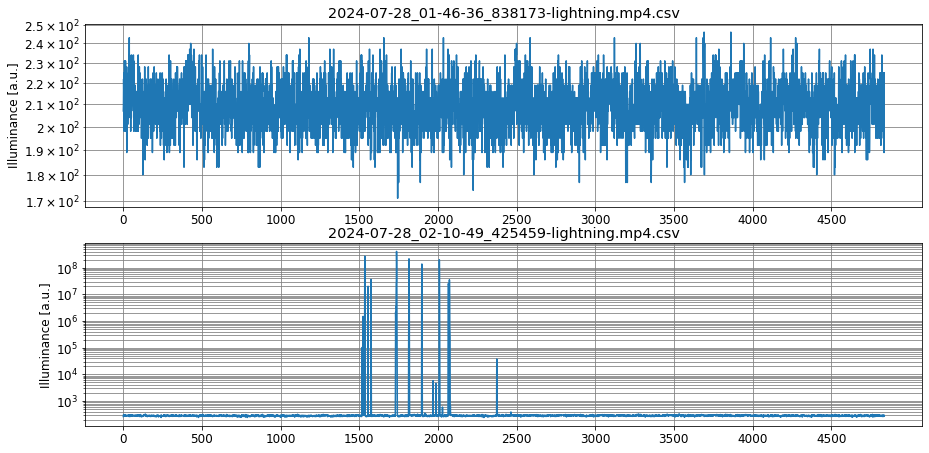

In [13]:
from matplotlib.gridspec import GridSpec

gs=GridSpec(20,1)
fig = plt.figure(figsize=(15,80))
plt.rc('font', size=12)    

i = 0
for f in glob.iglob(directory + "/*.mp4.csv"): # generator, search immediate subdirectories 
    try:
        s = f.split('/')
        st = s[len(s)-1]
        print(f)
        y = pd.read_csv(f)

        plt.subplot(gs[i,0])
        plt.plot(y['0'])
        plt.yscale('log')
        plt.title(st)
        #plt.xlabel('Frame [-]')
        plt.ylabel('Illuminance [a.u.]')
        plt.grid(visible=True, which='major', color='grey', linestyle='-')
        plt.grid(visible=True, which='minor', color='grey', linestyle='-')
        plt.xticks(np.arange(0, 5000, 500))
        i += 1
    except:
        pass

    
fig.savefig(directory + '/output/list.png')


# Plot Light Curves in correct Time

/storage/experiments/2024/0727_bourka_sobeslav/chronos/2024-07-28_02-10-49_425459-lightning.mp4.csv


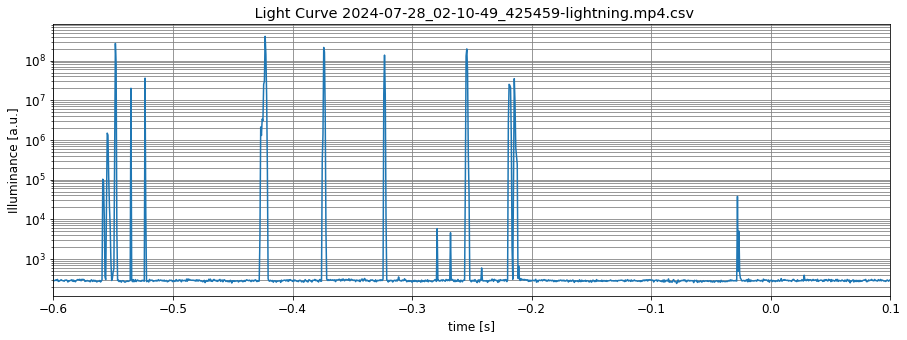

In [241]:
for f in glob.iglob(directory + "/*10-49*.mp4.csv"): # generator, search immediate subdirectories 
    try:
        s = f.split('/')
        st = s[len(s)-1]
        print(f)
        y = pd.read_csv(f)
        y['time'] = (y.index - (4838/2))*(3/4838)

        plt.figure(figsize=(15,5))
        plt.rc('font', size=12)    

        plt.plot(y['time'],y['0'])
        plt.yscale('log')
        #plt.ylim(200,1e3)
        plt.xlim(-0.6,0.1)
        plt.title(' Light Curve ' + st)
        plt.xlabel('time [s]')
        plt.ylabel('Illuminance [a.u.]')
        plt.grid(which='major', color='grey', linestyle='-')
        plt.grid(which='minor', color='grey', linestyle='-')
        #plt.xticks(np.arange(-1, 1, 0.1))

    except:
        pass


/storage/experiments/2024/0727_bourka_sobeslav/chronos/2024-07-28_02-10-49_425459-lightning.mp4.csv


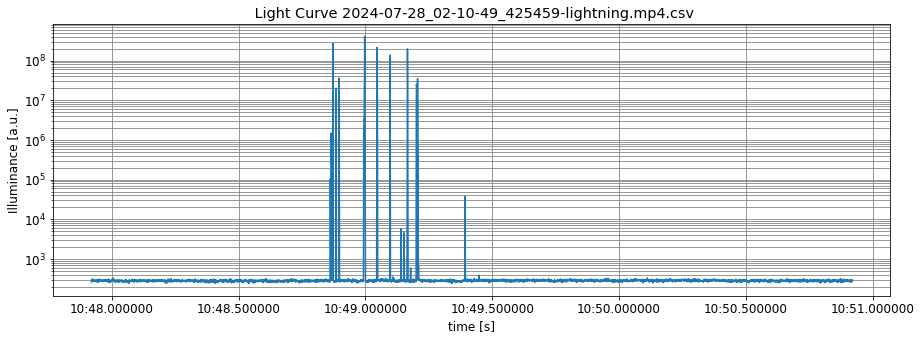

In [242]:
for f in glob.iglob(directory + "/*10-49*.mp4.csv"): # generator, search immediate subdirectories 
    try:
        s = f.split('/')
        st = s[len(s)-1]
        print(f)
        y = pd.read_csv(f)
        y['time'] = (y.index - (4838/2))*(3/4838)
        y['abstime'] = pd.to_datetime('2024-07-28 02:10:49.42') + pd.to_timedelta(y['time'], 's')
        
        
        plt.figure(figsize=(15,5))
        plt.rc('font', size=12)    

        plt.plot(y['abstime'],y['0'])
        plt.yscale('log')
        plt.title(' Light Curve ' + st)
        plt.xlabel('time [s]')
        plt.ylabel('Illuminance [a.u.]')
        plt.grid(which='major', color='grey', linestyle='-')
        plt.grid(which='minor', color='grey', linestyle='-')
        #plt.xticks(np.arange(-1, 1, 0.1))

    except:
        pass


In [243]:
f = '/storage/experiments/2024/0727_bourka_sobeslav/thundermill/nerezlog_20240728_012024_UTC.csv'

l=[]
l.extend(range(0,20))
df = pd.read_table(f, sep=',', header=None, comment='*',engine='python' )

df['time'] = pd.to_datetime(df[0], unit='s')
df.set_index('time', inplace=True, drop=False)


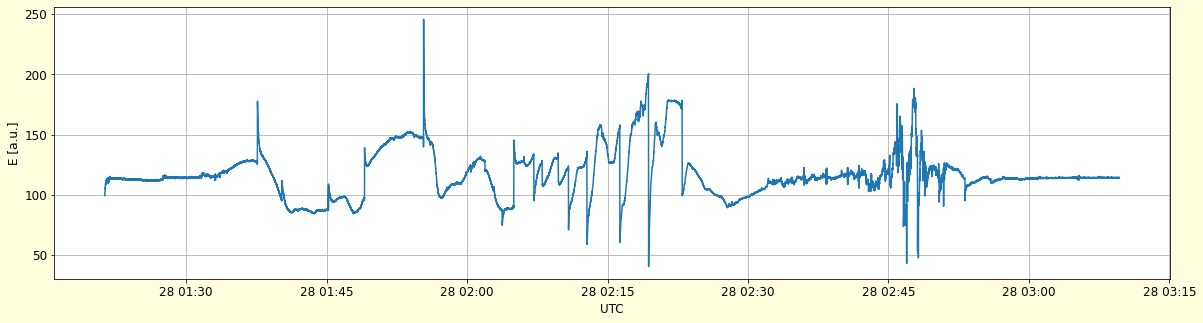

In [244]:
plt.figure(figsize=(20,5), facecolor='lightyellow')
plt.rc('font', size=12)    

df['mean'] = df[30].rolling(20).mean()

#plt.plot(df.loc['2024-07-03 18:10':'2024-07-03 19:40','mean'])
plt.plot(df['mean'])
#plt.ylim(10,140)
plt.xlabel('UTC')
plt.ylabel('E [a.u.]')
plt.grid()


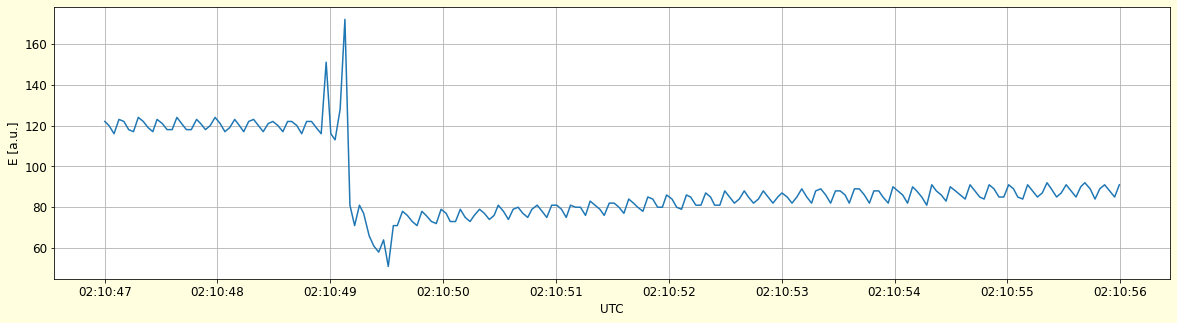

In [245]:
plt.figure(figsize=(20,5), facecolor='lightyellow')
plt.rc('font', size=12)    

#plt.plot(df.loc['2024-07-03 18:10':'2024-07-03 19:40','mean'])
plt.plot(df.loc['2024-07-28 02:10:47':'2024-07-28 02:10:55',30])
#plt.plot(df[30])
#plt.ylim(10,140)
plt.xlabel('UTC')
plt.ylabel('E [a.u.]')
plt.grid()


Text(0, 0.5, 'E [a.u.]')

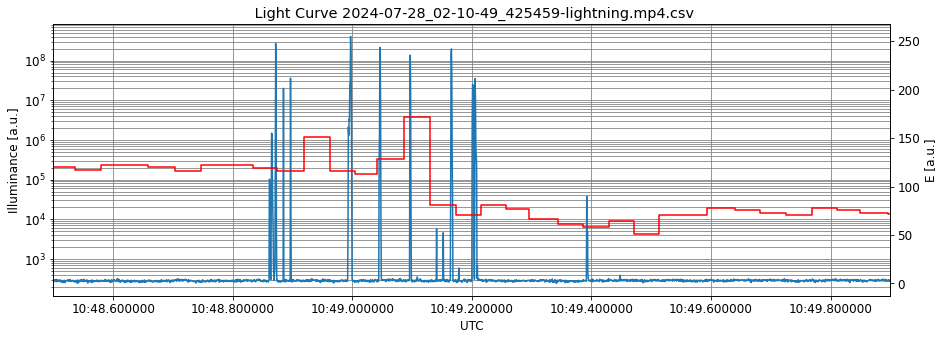

In [246]:
plt.figure(figsize=(15,5))
plt.rc('font', size=12)    

plt.plot(y['abstime'],y['0'])
plt.yscale('log')
plt.title(' Light Curve ' + st)
plt.ylabel('Illuminance [a.u.]')
plt.grid(which='major', color='grey', linestyle='-')
plt.grid(which='minor', color='grey', linestyle='-')
plt.xlabel('UTC')
plt.xlim(pd.to_datetime('2024-07-28 02:10:48.5'),pd.to_datetime('2024-07-28 02:10:49.9'))

plt.twinx()

plt.plot(df[30], color='red', drawstyle='steps-pre')
#plt.plot(df.loc['2024-07-28 02:10:48.5':'2024-07-28 02:10:49',30], color='red', drawstyle='steps-mid')
#plt.plot(df[30])
#plt.ylim(10,140)
plt.ylabel('E [a.u.]')


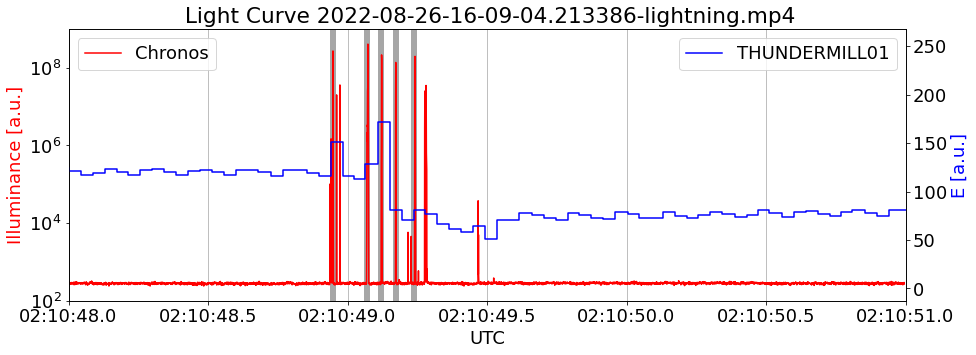

In [262]:
plt.figure(figsize=(15,5))
plt.rc('font', size=18)    


plt.vlines([pd.to_datetime('2024-07-28 02:10:48.9487'),pd.to_datetime('2024-07-28 02:10:49.07'),pd.to_datetime('2024-07-28 02:10:49.1193'),pd.to_datetime('2024-07-28 02:10:49.172'),pd.to_datetime('2024-07-28 02:10:49.2393')],ymin=0,ymax=1e9, lw=6, color='gray', alpha=0.7)

plt.plot(y['abstime'] + pd.to_timedelta(0.076, 's'),y['0'], label='Chronos', color='red')
plt.yscale('log')
plt.ylim(1e2,1e9)
plt.title(' Light Curve ' + st)
plt.ylabel('Illuminance [a.u.]', color='red')
#plt.grid(which='major', color='grey', linestyle='-')
#plt.grid(which='minor', color='grey', linestyle='-')
plt.grid(axis='x')
plt.xlabel('UTC')
ax = plt.gca()
xfmt = lambda x, pos: mdates.DateFormatter('%H:%M:%S.%f')(x)[:-5]
ax.xaxis.set_major_formatter(plt.FuncFormatter(xfmt))
plt.tick_params(axis='x', labelrotation=0)
#plt.xlim(pd.to_datetime('2024-07-28 02:10:48.5'),pd.to_datetime('2024-07-28 02:10:49.9'))
plt.xlim(pd.to_datetime('2024-07-28 02:10:48'),pd.to_datetime('2024-07-28 02:10:51'))
plt.legend(loc=2)

plt.twinx()

plt.plot(df[30], color='blue', drawstyle='steps-mid', label='THUNDERMILL01')
#plt.plot(df.loc['2024-07-28 02:10:48.5':'2024-07-28 02:10:49',30], color='red', drawstyle='steps-mid')
#plt.plot(df[30])
#plt.ylim(10,140)
plt.ylabel('E [a.u.]', color='blue')
plt.legend(loc=1)

#plt.vlines([pd.to_datetime('2024-07-28 02:10:48.948'),pd.to_datetime('2024-07-28 02:10:49.07'),pd.to_datetime('2024-07-28 02:10:49.1195'),pd.to_datetime('2024-07-28 02:10:49.172'),pd.to_datetime('2024-07-28 02:10:49.2395')],ymin=0,ymax=255, lw=5, color='yellow', alpha=0.5)

plt.savefig("/home/kakl/thesis_parallella/pic/fig_thundermill_2.png", format="png", dpi=300, bbox_inches="tight")


# TO DO:

# Plot Light Curves in correct Time

# Plot Light Curve together with Antenna data

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <class 'pandas.core.series.Series'> cannot be safely interpreted as an integer.


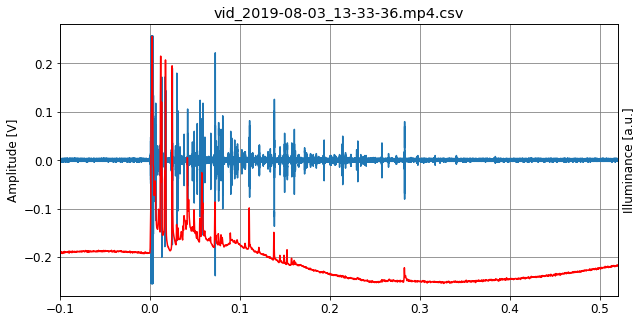

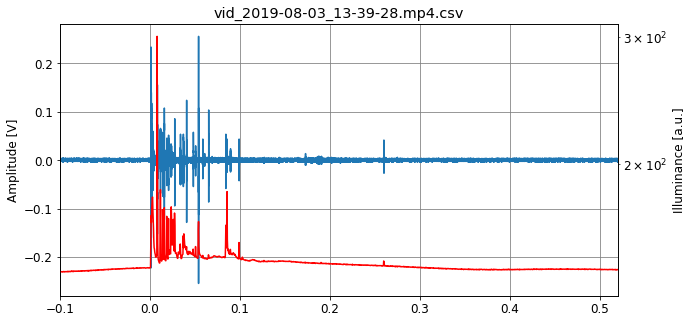

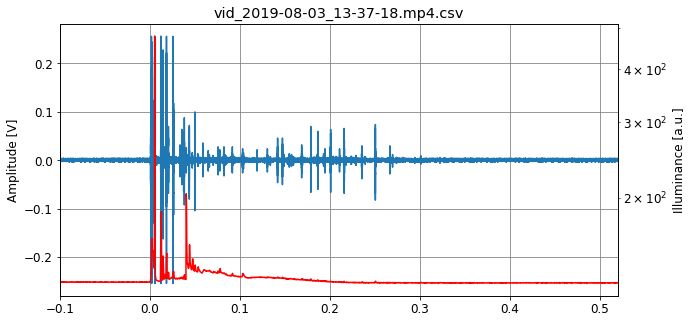

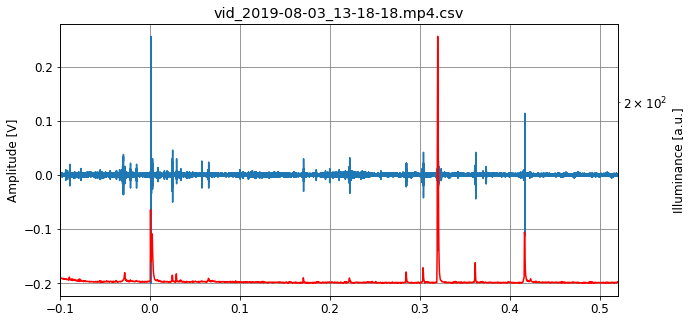

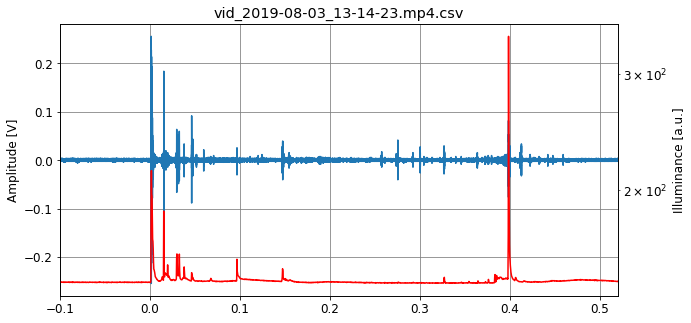

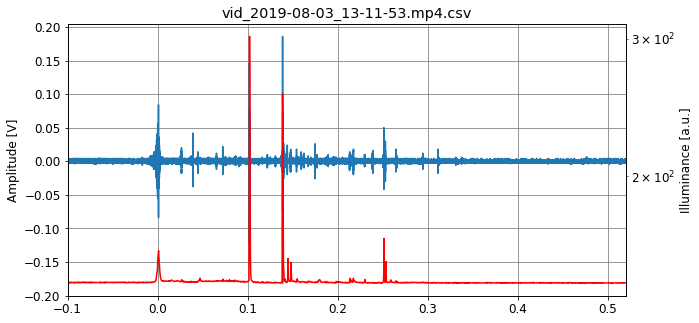

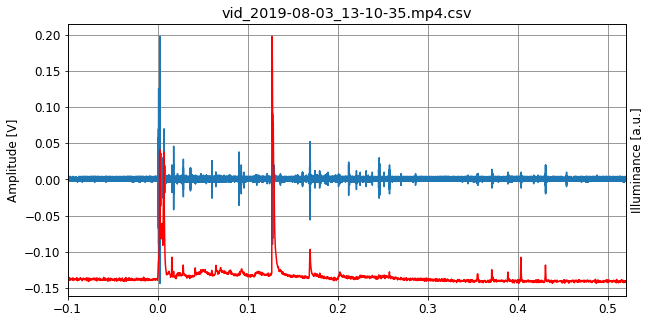

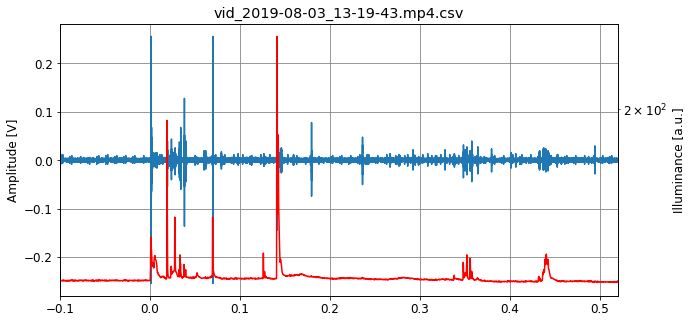

In [155]:
%matplotlib inline

for f in glob.iglob("./data/*.*.csv"): # generator, search immediate subdirectories 
    try:
        s = f.split('/')
        st = s[len(s)-1]
        ss = st.split('.')
        sst = ss[0] + '.' + ss[1]

        y = pd.read_csv(f)

        df = pd.read_table('./data/' + sst + '_first_frame', sep=',', header=None, engine='python' )


        
        param = pd.read_table('./antenna/' + df.iloc[0,4], sep=',', nrows=1, header=0, comment='*',engine='python' )

        timeinc = param['Increment']
        timeoffset = param['Start']

        dfa = pd.read_table('./antenna/' + df.iloc[0,4], sep=',', skiprows=2, header=None, comment='*',engine='python' )

        dfa[0] = pd.to_numeric(dfa[0])

        dfa[0]*=float(param['Increment'])
        dfa[0]+=float(param['Start'])


        plt.figure(figsize=(10,5))
        plt.rc('font', size=12)    

        plt.plot(dfa[0],dfa[1])

        plt.grid(b=True, which='major', color='grey', linestyle='-')
        plt.ylabel('Amplitude [V]')
        plt.xlim(-0.1,0.52)

        plt.twinx()
        
        plt.plot(np.linspace(df[1],df[3],df[2]-df[0]),y.iloc[:int(df[2]-df[0]),1], c='r')
        plt.yscale('log')
        plt.title(st)
        plt.xlabel('Time [s]')
        plt.ylabel('Illuminance [a.u.]')
    except:
        pass

    



# SLAVIA

In [43]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import time
import pandas as pd 
import datetime 

directory = "/storage/experiments/2021/0725_bourka_ratmirov"

f = directory + "/video/output/1627302288.9546976.mp4"
vidcap = cv2.VideoCapture(f)
success,image = vidcap.read()

time_string = "25/07/21 18:24:47.956"
format_string = "%d/%m/%y %H:%M:%S.%f"
t = datetime.datetime.strptime(time_string, format_string)
t += datetime.timedelta(microseconds=620)

count = 0
count2 = 0
success,image = vidcap.read()
#stacked = np.float32(image)
#stacked = image
while True:
    success,image = vidcap.read()
    if (success):
        stacked = cv2.add(image*.5,stacked)
        #stacked = cv2.addWeighted(stacked,1,image,1,0.5)
        #stacked = cv2.phaseCorrelate(image,stacked)
        #stacked = (stacked+image*.1);
    else:
        break

cv2.imwrite(directory + '/video/output/img/stacked.jpg', stacked)     # save frame as JPEG file

vidcap.release()
        
print('end')

end


In [115]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import time
import pandas as pd 
import datetime 

#directory = "/storage/experiments/2021/0725_bourka_ratmirov"
directory = "/storage/experiments/2021/video_lightning_highlights"

f = directory + "/video/2021-08-15-20-07-35.912167-lightning.mp4"
vidcap = cv2.VideoCapture(f)
success,image = vidcap.read()

time_string = "25/07/21 18:24:47.956"
format_string = "%d/%m/%y %H:%M:%S.%f"
t = datetime.datetime.strptime(time_string, format_string)
t += datetime.timedelta(microseconds=620)

count = 0
count2 = 0
success,image1 = vidcap.read()
stacked = cv2.bitwise_xor(image1,image1)
#cv2.imwrite(directory + '/video/output/img/stacked1.jpg', stacked)     # save frame as JPEG file

while True:
    success,image = vidcap.read()
    count += 1
    if (count > 0): 
        break;
    
#stacked = np.float32(image)
#stacked = image
while True:
    success,image = vidcap.read()
    #success,image2 = vidcap.read()
    if (success):
        #image = cv2.bitwise_xor(image1,image2)
        #stacked = cv2.add(image,stacked)
        rave = image.ravel()
        illuminance = rave.sum()
        brightest = rave.max()

        if (illuminance < 6e6 ): #6e6
            th, dst = cv2.threshold(image, brightest-200, None, cv2.THRESH_TOZERO);
            #stacked = cv2.addWeighted(dst, 1.0, stacked, 1.0, 0.0)
            stacked = cv2.add(dst, stacked)
        #stacked = cv2.normalize(stacked, None, alpha=0,beta=275, norm_type=cv2.NORM_MINMAX)
        #stacked = cv2.normalize(stacked, None, alpha=1,beta=0, norm_type=cv2.NORM_L2)
        #stacked = cv2.addWeighted(stacked,1,image,1,0.5)
        #stacked = cv2.phaseCorrelate(image,stacked)
        #stacked = (stacked+image*.1);
    else:
        break

cv2.imwrite(directory + '/video/output/img/stacked.jpg', stacked)     # save frame as JPEG file

vidcap.release()
        
print('end')

end


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import time
import pandas as pd

directory = "/storage/experiments/2021/video_lightning_highlights"

file = 'untitled.mp4'

# Logarithmic transformation
def log(c, img):
    output = c * np.log(1.0 + img)
    output = np.uint8(output)
    #output = c * np.log(1.0 + img)
    #output = np.uint8(output + 0.5)
    return output

try:
    os.mkdir(directory + '/video/output')
except:
    pass

f = directory + "/video/" + file 
    
b = np.zeros(30000)

vcap = cv2.VideoCapture(f)

if vcap.isOpened(): 
    # get vcap property 
    width  = vcap.get(3)  # float `width`
    height = vcap.get(4)  # float `height`

print(width, ' x ', height)
vcap.release()


fourcc = cv2.VideoWriter_fourcc(*'MP4V')
out = cv2.VideoWriter(directory + '/video/output/' + file , fourcc, 20.0, (round(width),round(height)))

cap = cv2.VideoCapture(f)


lut = np.zeros((256, 1, 3), dtype=np.uint8)

#Red
lut[:, 0, 0] = [255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,253,251,249,247,245,242,241,238,237,235,233,231,229,227,225,223,221,219,217,215,213,211,209,207,205,203,201,199,197,195,193,191,189,187,185,183,181,179,177,175,173,171,169,167,165,163,161,159,157,155,153,151,149,147,145,143,141,138,136,134,132,131,129,126,125,122,121,118,116,115,113,111,109,107,105,102,100,98,97,94,93,91,89,87,84,83,81,79,77,75,73,70,68,66,64,63,61,59,57,54,52,51,49,47,44,42,40,39,37,34,33,31,29,27,25,22,20,18,17,14,13,11,9,6,4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

#Green
lut[:, 0, 1] = [ 255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,254,252,250,248,246,244,242,240,238,236,234,232,230,228,226,224,222,220,218,216,214,212,210,208,206,204,202,200,198,196,194,192,190,188,186,184,182,180,178,176,174,171,169,167,165,163,161,159,157,155,153,151,149,147,145,143,141,139,137,135,133,131,129,127,125,123,121,119,117,115,113,111,109,107,105,103,101,99,97,95,93,91,89,87,85,83,82,80,78,76,74,72,70,68,66,64,62,60,58,56,54,52,50,48,46,44,42,40,38,36,34,32,30,28,26,24,22,20,18,16,14,12,10,8,6,4,2,0 ]

#Blue
lut[:, 0, 2] = [195,194,193,191,190,189,188,187,186,185,184,183,182,181,179,178,177,176,175,174,173,172,171,170,169,167,166,165,164,163,162,161,160,159,158,157,155,154,153,152,151,150,149,148,147,146,145,143,142,141,140,139,138,137,136,135,134,133,131,130,129,128,127,126,125,125,125,125,125,125,125,125,125,125,125,125,125,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126]

def get_mpl_colormap(cmap_name):
    cmap = plt.get_cmap(cmap_name)

    # Initialize the matplotlib color map
    sm = plt.cm.ScalarMappable(cmap=cmap)

    # Obtain linear color range
    color_range = sm.to_rgba(np.linspace(0, 1, 256), bytes=True)[:,2::-1]

    return color_range.reshape(256, 1, 3)


success,image1 = cap.read()

count = 0
while True:
    ret,frame = cap.read()
    if not(ret):
        break

    #frame_log = log(255,frame)
    
    #rave = frame[10:800, 100:800].ravel()
    #brightest = rave.max()
    #print(brightest)
    
    frame_color = cv2.applyColorMap(frame*2, cv2.COLORMAP_PLASMA)
    #frame_color = cv2.applyColorMap(frame, get_mpl_colormap('plasma'))
    #frame_color = cv2.LUT(frame, lut)

    count = count + 1
    out.write(frame_color)

cap.release()
out.release()
print(f)
        
print('end')

In [ ]:
%matplotlib ipympl
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()


x = np.linspace(0, 2*np.pi, 100)
y = np.sin(3*x)
ax.plot(x, y)

## Specialne pro stary zaznam iniciace

In [174]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import time
import pandas as pd 

#directory = "/storage/experiments/2021/0711_bourka_stiavnica"

# Logarithmic transformation
def log(c, img):
    output = c * np.log(1.0 + img)
    output = np.uint8(output + 0.5)
    return output

try:
    os.mkdir(directory + '/output')
except:
    pass

for f in glob.iglob(directory + "/*10-48-*.mp4"): # generator, search immediate subdirectories 
    s = f.split('/')
    st = s[len(s)-1]
    print(st)

    b = np.zeros(30000)

    vcap = cv2.VideoCapture(f)

    if vcap.isOpened(): 
        # get vcap property 
        width  = vcap.get(3)  # float `width`
        height = vcap.get(4)  # float `height`

    print(width, ' x ', height)
    vcap.release()

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    #out = cv2.VideoWriter(directory + '/video/output/' + st , fourcc, 20.0, (928,928+150))
    out = cv2.VideoWriter(directory + '/output/' + st, fourcc, 20.0, (round(width),round(height)+150))

    cap = cv2.VideoCapture(f)
    video_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(video_length)

    img = cv2.imread(directory + '/output/' + st + '.csv.png')
    img_not = cv2.bitwise_not(img)

    # Center coordinates
    center_coordinates = (round(width/2), round(height/2))
    # Radius of circle
    radius = round(width/2)-45
    # Line thickness in px
    line_thickness = 1
    font_thickness = 1
    font_scale = 0.8

    count = 0
    while True:
        ret,frame = cap.read()
        if not(ret):
            break
            
        count = count + 1
        if((count>1700)and(count<3000)):
            for n in range(0,256):
                for i in range(round(width)-20,round(width)):
                    frame[n+20,i] = n

            #(B, G, R) = cv2.split(frame)
            #frame = cv2.merge([B,B,B])
            frame_log = log(42,frame)
            frame_color = frame_log[:round(height)-40]

            frame_color = cv2.applyColorMap(frame_color, cv2.COLORMAP_JET)
            
            color = (0, 255, 0) # green
            cv2.circle(frame_color, center_coordinates, radius, color, 1, cv2.LINE_AA)

            v_img = cv2.vconcat([img_not[:,:-1], frame_color, frame[round(width)-40:round(width)]])

            pointer = round(count*(width/video_length))
            cv2.line(v_img,(pointer,140),(pointer,160),(0,255,0),2)
            cv2.line(v_img,(pointer,60),(pointer,80),(0,255,0),2)
            out.write(v_img)
            #cv2.imwrite(directory + '/video/output/ble.png', v_img)     # save frame as JPEG file
            #break

    cap.release()
    out.release()
    print(f)
        
print('end')

vid_2021-06-09_10-48-35.mp4
800.0  x  600.0
8610
/storage/experiments/2021/0609_bourka_sobeslav/video/vid_2021-06-09_10-48-35.mp4
end


In [182]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import time
import pandas as pd 

#directory = "/storage/experiments/2021/0711_bourka_stiavnica"

# Logarithmic transformation
def log(c, img):
    output = c * np.log(0.1 + img)
    output = np.uint8(output + 0.0)
    return output

try:
    os.mkdir(directory + '/output')
except:
    pass

for f in glob.iglob(directory + "/*10-48*.mp4"): # generator, search immediate subdirectories 
    s = f.split('/')
    st = s[len(s)-1]
    print(st)

    b = np.zeros(30000)

    vcap = cv2.VideoCapture(f)

    if vcap.isOpened(): 
        # get vcap property 
        width  = vcap.get(3)  # float `width`
        height = vcap.get(4)  # float `height`

    print(width, ' x ', height)
    vcap.release()

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    #out = cv2.VideoWriter(directory + '/video/output/' + st , fourcc, 20.0, (928,928+150))
    out = cv2.VideoWriter(directory + '/output/' + st, fourcc, 20.0, (round(width),round(height)+150))

    cap = cv2.VideoCapture(f)
    video_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(video_length)

    img = cv2.imread(directory + '/output/' + st + '.csv.png')
    img_not = cv2.bitwise_not(img)

    # Center coordinates
    center_coordinates = (round(width/2), round(height/2))
    # Radius of circle
    radius = round(width/2)-45
    # Line thickness in px
    line_thickness = 1
    font_thickness = 1
    font_scale = 0.8

    count = 0
    while True:
        ret,frame = cap.read()
        if not(ret):
            break
            
        count = count + 1
        if((count>1800)and(count<3000)):
            for n in range(0,256):
                for i in range(round(width)-20,round(width)):
                    frame[n+20,i] = n

            #(B, G, R) = cv2.split(frame)
            #frame = cv2.merge([B,255-G,R])
            #frame_log = log(50,frame)
            frame_log = (frame)
            frame_color = frame_log[:round(width)-40]

            frame_color = cv2.applyColorMap(frame_color, cv2.COLORMAP_JET)
            
            color = (0, 255, 0) # green
            cv2.circle(frame_color, center_coordinates, radius, color, 1, cv2.LINE_AA)

            font = cv2.FONT_HERSHEY_SIMPLEX
            color = (255, 255, 255) # white
            text = "0"
            position = (round(width) - 35, 40)
            cv2.putText(frame_color, text, position, font, color=color, thickness = font_thickness, fontScale=font_scale-0.2, lineType = cv2.LINE_AA)
            text = "255"
            position = (round(width) - 60, 275)
            cv2.putText(frame_color, text, position, font, color=color, thickness = font_thickness, fontScale=font_scale-0.2, lineType = cv2.LINE_AA)
                                    
            v_img = cv2.vconcat([img_not[:,:-1], frame_color, frame[round(width)-40:round(width)]])

            pointer = round(count*(width/video_length))
            cv2.line(v_img,(pointer,140),(pointer,160),(0,255,0),2)
            cv2.line(v_img,(pointer,60),(pointer,80),(0,255,0),2)
            out.write(v_img)
            #cv2.imwrite(directory + '/video/output/ble.png', v_img)     # save frame as JPEG file
            #break

    cap.release()
    out.release()
    print(f)
        
print('end')

vid_2021-06-09_10-48-35.mp4
800.0  x  600.0
8610
/storage/experiments/2021/0609_bourka_sobeslav/video/vid_2021-06-09_10-48-35.mp4
end


In [148]:
frame_color.shape

(600, 800, 3)

In [153]:
img_not[:,:-1].shape

(150, 800, 3)

In [150]:
frame.shape

(600, 800, 3)